Install these dependencies first before importing gym environment.

In [1]:
!pip3 install box2d-py
!pip3 install gym[Box_2D]

     |████████████████████████████████| 448 kB 8.3 MB/s 


Follow the documentation about the environment in the DDPG notebook.
https://colab.research.google.com/drive/12wE2J4eeqx09OEa-NBdgZRidToNhTocu#scrollTo=ZRYcHY59ysto

In [2]:
import gym
env = gym.make("LunarLanderContinuous-v2")

In [3]:
import os
import numpy as np
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import gym
import matplotlib.pyplot as plt
from torch.distributions.normal import Normal
from tqdm import tqdm

SAC solves continuous state/action spaces by maximising both the rewards and the entropy, or the randomness of choosing actions. It uses a Replay Buffer to sample its memories or training data. SAC agent uses a number of networks, namely the Actor Network, the Value Network, the Target Value Network and two Critic networks. The output of the Actor is a stochastic policy $\pi$ (to select actions. The output of the two Critic networks is the state action value(Q),and the output of the Value network is state value (V). The Target Value network is not used for training, however it soft updated with the weights of the base Value network at the rate of the update parameter $\tau$


In [6]:
class ReplayBuffer(object):

    """
     A FIFO experience replay buffer for SAC agents.
     Arguments maximum size,input shape and number of actions.
     Stores in memory current state, new state, action,reward and terminal state.

     All of the actions and observations that the agent has taken from the beginning, 
     limited by the capacity of the memory, are stored. Then a batch of samples is randomly
     selected from this memory. This ensures that the batch is ‘shuffled’ and contains enough 
     diversity from older and newer samples to allow the network to learn weights that generalize 
     to all the scenarios that it will be required to handle.

     """
    def __init__(self, max_size, input_shape, n_actions):
        self.mem_size = max_size
        self.mem_cntr = 0
        self.state_memory = np.zeros((self.mem_size, *input_shape))
        self.new_state_memory = np.zeros((self.mem_size, *input_shape))
        self.action_memory = np.zeros((self.mem_size, n_actions))
        self.reward_memory = np.zeros(self.mem_size)
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.bool)

    def store_transition(self, state, action, reward, state_, done):
        index = self.mem_cntr % self.mem_size

        self.state_memory[index] = state
        self.new_state_memory[index] = state_
        self.action_memory[index] = action
        self.reward_memory[index] = reward
        self.terminal_memory[index] = done

        self.mem_cntr += 1

    def sample_buffer(self, batch_size):
        max_mem = min(self.mem_cntr, self.mem_size) # It will pick the minimum of these two memory sizes and only sample 
                                                    # those many memories to avoid searching the whole buffer

        batch = np.random.choice(max_mem, batch_size)

        states = self.state_memory[batch]
        states_ = self.new_state_memory[batch]
        actions = self.action_memory[batch]
        rewards = self.reward_memory[batch]
        dones = self.terminal_memory[batch]

        return states, actions, rewards, states_, dones


class CriticNetwork(nn.Module):

    """
      This is the Critic Network. Our Critic Network has 2 fully connected layers that use 
      ReLu as activation function.     
      We are using ADAM as the activation function in the output layer
      Arguments: 
      1. Beta -> Learning Rate
      2. Input Dimensions
      3. Number of actions -> Depends on environment
      4. Dimensions of Fully Connected Layer 1 ( 256 as per the original paper)
      5. Dimensions of Fully Connected Layer 2 ( 256 as per original paper)
      6. Name -> To distiguish between critic1 and critic2
      7. Checkpoint directory -> To save critic weights and biases.

      Output -> q value


      """
    def __init__(self, beta, input_dims, n_actions, fc1_dims=256, fc2_dims=256,
            name='critic', chkpt_dir='/content/drive/MyDrive/RLFinal/SAC'):
        super(CriticNetwork, self).__init__()
        self.input_dims = input_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = n_actions
        self.name = name
        self.checkpoint_dir = chkpt_dir
        self.checkpoint_file = os.path.join(self.checkpoint_dir, name+'_sac')

        self.fc1 = nn.Linear(self.input_dims[0]+n_actions, self.fc1_dims) # state and action vectors passed in input
        self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)
        self.q = nn.Linear(self.fc2_dims, 1)

        self.optimizer = optim.Adam(self.parameters(), lr=beta)
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')

        self.to(self.device)

    def forward(self, state, action):
        action_value = self.fc1(T.cat([state, action], dim=1))
        action_value = F.relu(action_value)
        action_value = self.fc2(action_value)
        action_value = F.relu(action_value)

        q = self.q(action_value)

        return q

    def save_checkpoint(self):
        T.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        self.load_state_dict(T.load(self.checkpoint_file))

class ValueNetwork(nn.Module):

    """
    The Value network is used to calculate the state value
    Arguments: 
      1. Beta -> Learning Rate
      2. Input Dimensions
      3. Dimensions of Fully Connected Layer 1 ( 256 as per the original paper)
      4. Dimensions of Fully Connected Layer 2 ( 256 as per original paper)
      5. Name -> To distiguish between critic1 and critic2
      6. Checkpoint directory -> To save critic weights and biases.

      Output : Value(V)
      """
    def __init__(self, beta, input_dims, fc1_dims=256, fc2_dims=256,
            name='value', chkpt_dir='/content/drive/MyDrive/RLFinal/SAC'):
        super(ValueNetwork, self).__init__()
        self.input_dims = input_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.name = name
        self.checkpoint_dir = chkpt_dir
        self.checkpoint_file = os.path.join(self.checkpoint_dir, name+'_sac')

        self.fc1 = nn.Linear(*self.input_dims, self.fc1_dims)
        self.fc2 = nn.Linear(self.fc1_dims, fc2_dims)
        self.v = nn.Linear(self.fc2_dims, 1)

        self.optimizer = optim.Adam(self.parameters(), lr=beta)
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')

        self.to(self.device)

    def forward(self, state):
        state_value = self.fc1(state)
        state_value = F.relu(state_value)
        state_value = self.fc2(state_value)
        state_value = F.relu(state_value)

        v = self.v(state_value)

        return v

    def save_checkpoint(self):
        T.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        self.load_state_dict(T.load(self.checkpoint_file))


class ActorNetwork(nn.Module):
    """
      This is the policy network. It takes as input the state and actions and outputs the Mu and Sigma
      values to create a normal distribution from which we sample our actions.Final activation function is Tanh.

      1. Alpha -> Learning Rate
      2. Input Dimensions
      3. Max action -> Upper bound of action. For Lunar Lander it is 1.
      3. Dimensions of Fully Connected Layer 1 ( 256 as per the original paper)
      4. Dimensions of Fully Connected Layer 2 ( 256 as per original paper)
      5. Number of actions (from the environment)
      5. Name -> To distinguish between base actor and target actor
      6. Checkpoint directory -> To save actor weights and biases.

      Output-> Action and log probabilities of action
    """
    def __init__(self, alpha, input_dims, max_action, fc1_dims=256, 
            fc2_dims=256, n_actions=2, name='actor', chkpt_dir='/content/drive/MyDrive/RLFinal/SAC'):
        super(ActorNetwork, self).__init__()
        self.input_dims = input_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = n_actions
        self.name = name
        self.checkpoint_dir = chkpt_dir
        self.checkpoint_file = os.path.join(self.checkpoint_dir, name+'_sac')
        self.max_action = max_action
        self.reparam_noise = 1e-6 # reparametrization

        self.fc1 = nn.Linear(*self.input_dims, self.fc1_dims)
        self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)
        self.mu = nn.Linear(self.fc2_dims, self.n_actions)
        self.sigma = nn.Linear(self.fc2_dims, self.n_actions)

        self.optimizer = optim.Adam(self.parameters(), lr=alpha)
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')

        self.to(self.device)

    def forward(self, state):
        prob = self.fc1(state)
        prob = F.relu(prob)
        prob = self.fc2(prob)
        prob = F.relu(prob)

        mu = self.mu(prob)
        sigma = self.sigma(prob)

        sigma = T.clamp(sigma, min=self.reparam_noise, max=1) # bounding the Standard deviation of the distribution within the min and max value. 
                                                               # Not choosing negative lower bound due to pytorch complications                                                              

        return mu, sigma

    def sample_normal(self, state, reparameterize=True):
        mu, sigma = self.forward(state)
        probabilities = Normal(mu, sigma)

        if reparameterize:
            actions = probabilities.rsample() # adding some noise to random samples
        else:
            actions = probabilities.sample()  # random sample

        action = T.tanh(actions)*T.tensor(self.max_action).to(self.device) #
        log_probs = probabilities.log_prob(actions)
        log_probs -= T.log(1-action.pow(2)+self.reparam_noise)
        log_probs = log_probs.sum(1, keepdim=True)

        return action, log_probs

    def save_checkpoint(self):
        T.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        self.load_state_dict(T.load(self.checkpoint_file))

class Agent():

    """
     The Agent consists of 1 Actor, 1 Value network , 1 Target Value Network and 2 Critics.
     Arguments:
     1. Alpha -> Actor's learning rate
     2. Beta -> Critic and Value network learning rate
     3. Input Dimensions
     4. Environment 
     5. Gamma -> Discount factor of agent
     6. Number of actions
     7. Maximum size of memory
     8. Tau -> soft update parameter for Target Value Network
     9. fc1 size
     10. fc2 size
     11. Batch size (batch learning in replay memory)
     12. Reward Scale (to incorporate the entropy calculation)

      We take the minimum of the action value output between critic 1 and critic 2 
      and subtract that from value estimated by Value network to derive Value network loss.

    """
    def __init__(self, alpha=0.0003, beta=0.0003, input_dims=[8],
            env=None, gamma=0.99, n_actions=2, max_size=1000000, tau=0.005,
            layer1_size=256, layer2_size=256, batch_size=256, reward_scale=2):
        self.gamma = gamma
        self.tau = tau
        self.memory = ReplayBuffer(max_size, input_dims, n_actions)
        self.batch_size = batch_size
        self.n_actions = n_actions

        self.actor = ActorNetwork(alpha, input_dims, n_actions=n_actions,
                    name='actor', max_action=env.action_space.high)
        self.critic_1 = CriticNetwork(beta, input_dims, n_actions=n_actions,
                    name='critic_1')
        self.critic_2 = CriticNetwork(beta, input_dims, n_actions=n_actions,
                    name='critic_2')
        self.value = ValueNetwork(beta, input_dims, name='value')
        self.target_value = ValueNetwork(beta, input_dims, name='target_value')

        self.scale = reward_scale
        self.update_network_parameters(tau=1) # copies parameters from base value network to target value network to initialise
                                              # after this, it does soft updates to target based on tau passed to the agent.

    def choose_action(self, observation):
        state = T.Tensor([observation]).to(self.actor.device)
        actions, _ = self.actor.sample_normal(state, reparameterize=False)

        return actions.cpu().detach().numpy()[0]

    def remember(self, state, action, reward, new_state, done):
        self.memory.store_transition(state, action, reward, new_state, done)

    def update_network_parameters(self, tau=None):
        if tau is None:
            tau = self.tau

        target_value_params = self.target_value.named_parameters()
        value_params = self.value.named_parameters()

        target_value_state_dict = dict(target_value_params)
        value_state_dict = dict(value_params)
        # soft update of target value network
        for name in value_state_dict:
            value_state_dict[name] = tau*value_state_dict[name].clone() + \
                    (1-tau)*target_value_state_dict[name].clone()

        self.target_value.load_state_dict(value_state_dict)

    def save_models(self):
        print('.... saving models ....')
        self.actor.save_checkpoint()
        self.value.save_checkpoint()
        self.target_value.save_checkpoint()
        self.critic_1.save_checkpoint()
        self.critic_2.save_checkpoint()

    def load_models(self):
        print('.... loading models ....')
        self.actor.load_checkpoint()
        self.value.load_checkpoint()
        self.target_value.load_checkpoint()
        self.critic_1.load_checkpoint()
        self.critic_2.load_checkpoint()

    def learn(self):
        if self.memory.mem_cntr < self.batch_size: ## learning starts only once memory buffer has at least one batch size worth of training data 
            return

        state, action, reward, new_state, done = \
                self.memory.sample_buffer(self.batch_size)

        reward = T.tensor(reward, dtype=T.float).to(self.actor.device)
        done = T.tensor(done).to(self.actor.device)
        state_ = T.tensor(new_state, dtype=T.float).to(self.actor.device)
        state = T.tensor(state, dtype=T.float).to(self.actor.device)
        action = T.tensor(action, dtype=T.float).to(self.actor.device)

        value = self.value(state).view(-1) # value of current state estimated by base
        value_ = self.target_value(state_).view(-1) # value of next state calculated by target
        value_[done] = 0.0 # value at terminal state

        actions, log_probs = self.actor.sample_normal(state, reparameterize=False)
        log_probs = log_probs.view(-1)
        q1_new_policy = self.critic_1.forward(state, actions)
        q2_new_policy = self.critic_2.forward(state, actions)
        critic_value = T.min(q1_new_policy, q2_new_policy)
        critic_value = critic_value.view(-1)

        self.value.optimizer.zero_grad() # stop gradients from previous steps from accumulating
        value_target = critic_value - log_probs  # Target value
        value_loss = 0.5 * F.mse_loss(value, value_target) # Value Loss , mse between value estimated by base and target value networks
        value_loss.backward(retain_graph=True)
        self.value.optimizer.step()

        actions, log_probs = self.actor.sample_normal(state, reparameterize=True) # get actions and log probs from actor
        log_probs = log_probs.view(-1)
        q1_new_policy = self.critic_1.forward(state, actions) # qvalue from critic 1 
        q2_new_policy = self.critic_2.forward(state, actions) #  qvalue from critic 2
        critic_value = T.min(q1_new_policy, q2_new_policy) # min of two values
        critic_value = critic_value.view(-1)
        
        actor_loss = log_probs - critic_value # actor loss, as per paper
        actor_loss = T.mean(actor_loss)
        self.actor.optimizer.zero_grad()
        actor_loss.backward(retain_graph=True)
        self.actor.optimizer.step()

        self.critic_1.optimizer.zero_grad()
        self.critic_2.optimizer.zero_grad()
        q_hat = self.scale*reward + self.gamma*value_ # Scaled reward includes the entropy. Estimated q value
        q1_old_policy = self.critic_1.forward(state, action).view(-1) # q value using sample from replay buffer by critic1
        q2_old_policy = self.critic_2.forward(state, action).view(-1) #  q value using sample from replay buffer by critic 2
        critic_1_loss = 0.5 * F.mse_loss(q1_old_policy, q_hat) # Loss between estimated Q value and q value calculated by critic 1 using memory data
        critic_2_loss = 0.5 * F.mse_loss(q2_old_policy, q_hat) # Loss between estimated Q value and q value calculated by critic 1 using memory data

        critic_loss = critic_1_loss + critic_2_loss # Total critic loss
        critic_loss.backward()
        self.critic_1.optimizer.step()
        self.critic_2.optimizer.step()

        self.update_network_parameters()


Function to Trace Learning Curve

In [11]:
def plot_learning_curve(x, scores, figure_file):
    running_avg = np.zeros(len(scores))
    for i in range(len(running_avg)):
        running_avg[i] = np.mean(scores[max(0, i-100):(i+1)])
    plt.plot(x, running_avg)
    plt.xlabel("Episodes")
    plt.ylabel("Rewards over last 100 episodes")
    plt.title('Running average of previous 100 scores')
    plt.savefig(figure_file)



Train the agent and plot progress

In [ ]:
agent = Agent(input_dims=env.observation_space.shape, env=env,
            n_actions=env.action_space.shape[0])


# Setting Number of episodes to 1000 for resuming training from where it finished earlier. For first time, it is 1000
num_episodes = 1500

#env = wrappers.Monitor(env, 'tmp/video', video_callable=lambda episode_id: True, force=True)

best_score = env.reward_range[0]
score_history = []
# Set checkpoint to False for training for the first time. To resume training for further episodes of semi trained models, set it to true.

#load_checkpoint = False
load_checkpoint = True



if load_checkpoint:
        agent.load_models()

score_history = []

for i in tqdm(range(1, num_episodes+1)):
  done = False
  score = 0
  obs = env.reset()

  while not done:
    act = agent.choose_action(obs)
    new_state,reward,done,info = env.step(act)
    agent.remember(obs,act,reward,new_state,int(done))
    agent.learn()
    score +=reward
    obs = new_state

  score_history.append(score)
  print('episode' ,i, 'score %.2f' %score, '100 game average %.2f' %np.mean(score_history[100:]))

  avg_score = np.mean(score_history[-100:])

  if avg_score > best_score:
    best_score = avg_score
    if not load_checkpoint:
       agent.save_models()
       print('episode ', i, 'score %.1f' % score, 'avg_score %.1f' % avg_score)

  # if i % 25 == 0:
  #   agent.save_models()

  # if not load_checkpoint:
  #       x = [i+1 for i in range(num_episodes)]
  #       plot_learning_curve(x, score_history, figure_file)



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


.... loading models ....


  0%|          | 0/1500 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
  0%|          | 1/1500 [00:13<5:38:44, 13.56s/it]

episode 1 score -29.05 100 game average nan


  0%|          | 2/1500 [00:29<6:09:35, 14.80s/it]

episode 2 score -52.17 100 game average nan


  0%|          | 3/1500 [00:44<6:17:49, 15.14s/it]

episode 3 score -48.64 100 game average nan


  0%|          | 4/1500 [01:01<6:33:11, 15.77s/it]

episode 4 score 12.19 100 game average nan


  0%|          | 5/1500 [01:17<6:30:46, 15.68s/it]

episode 5 score 1.82 100 game average nan


  0%|          | 6/1500 [01:33<6:33:51, 15.82s/it]

episode 6 score -23.71 100 game average nan


  0%|          | 7/1500 [01:49<6:35:59, 15.91s/it]

episode 7 score 9.72 100 game average nan


  1%|          | 8/1500 [01:50<4:40:29, 11.28s/it]

episode 8 score 56.64 100 game average nan


  1%|          | 9/1500 [02:06<5:15:55, 12.71s/it]

episode 9 score -39.23 100 game average nan


  1%|          | 10/1500 [02:22<5:37:43, 13.60s/it]

episode 10 score -43.16 100 game average nan


  1%|          | 11/1500 [02:23<4:07:44,  9.98s/it]

episode 11 score 5.81 100 game average nan


  1%|          | 12/1500 [02:38<4:43:14, 11.42s/it]

episode 12 score 9.72 100 game average nan


  1%|          | 13/1500 [02:54<5:16:01, 12.75s/it]

episode 13 score -4.83 100 game average nan


  1%|          | 14/1500 [03:10<5:39:19, 13.70s/it]

episode 14 score 19.90 100 game average nan


  1%|          | 15/1500 [03:25<5:53:01, 14.26s/it]

episode 15 score -57.68 100 game average nan


  1%|          | 16/1500 [03:41<6:05:38, 14.78s/it]

episode 16 score 6.82 100 game average nan


  1%|          | 17/1500 [03:57<6:10:17, 14.98s/it]

episode 17 score 2.48 100 game average nan


  1%|          | 18/1500 [04:13<6:17:05, 15.27s/it]

episode 18 score 37.02 100 game average nan


  1%|▏         | 19/1500 [04:28<6:20:14, 15.41s/it]

episode 19 score 23.83 100 game average nan


  1%|▏         | 20/1500 [04:44<6:21:24, 15.46s/it]

episode 20 score 31.92 100 game average nan


  1%|▏         | 21/1500 [05:01<6:31:29, 15.88s/it]

episode 21 score -13.99 100 game average nan


  1%|▏         | 22/1500 [05:17<6:31:15, 15.88s/it]

episode 22 score 2.22 100 game average nan


  2%|▏         | 23/1500 [05:32<6:25:54, 15.68s/it]

episode 23 score 20.47 100 game average nan


  2%|▏         | 24/1500 [05:48<6:28:39, 15.80s/it]

episode 24 score -10.71 100 game average nan


  2%|▏         | 25/1500 [06:05<6:33:41, 16.01s/it]

episode 25 score -47.05 100 game average nan


  2%|▏         | 26/1500 [06:19<6:24:48, 15.66s/it]

episode 26 score 4.47 100 game average nan


  2%|▏         | 27/1500 [06:34<6:17:59, 15.40s/it]

episode 27 score -27.02 100 game average nan


  2%|▏         | 28/1500 [06:50<6:23:40, 15.64s/it]

episode 28 score -25.31 100 game average nan


  2%|▏         | 29/1500 [07:06<6:20:49, 15.53s/it]

episode 29 score -5.76 100 game average nan


  2%|▏         | 30/1500 [07:22<6:26:30, 15.78s/it]

episode 30 score -6.95 100 game average nan


  2%|▏         | 31/1500 [07:38<6:29:51, 15.92s/it]

episode 31 score 18.88 100 game average nan


  2%|▏         | 32/1500 [07:54<6:26:02, 15.78s/it]

episode 32 score -6.54 100 game average nan


  2%|▏         | 33/1500 [08:10<6:29:47, 15.94s/it]

episode 33 score -22.40 100 game average nan


  2%|▏         | 34/1500 [08:25<6:23:49, 15.71s/it]

episode 34 score -3.36 100 game average nan


  2%|▏         | 35/1500 [08:42<6:28:01, 15.89s/it]

episode 35 score 2.80 100 game average nan


  2%|▏         | 36/1500 [08:58<6:31:42, 16.05s/it]

episode 36 score 11.89 100 game average nan


  2%|▏         | 37/1500 [09:14<6:28:08, 15.92s/it]

episode 37 score -3.53 100 game average nan


  3%|▎         | 38/1500 [09:29<6:22:44, 15.71s/it]

episode 38 score 11.70 100 game average nan


  3%|▎         | 39/1500 [09:44<6:18:08, 15.53s/it]

episode 39 score -11.61 100 game average nan


  3%|▎         | 40/1500 [10:00<6:19:34, 15.60s/it]

episode 40 score -9.88 100 game average nan


  3%|▎         | 41/1500 [10:15<6:18:47, 15.58s/it]

episode 41 score -28.43 100 game average nan


  3%|▎         | 42/1500 [10:31<6:24:03, 15.81s/it]

episode 42 score -14.96 100 game average nan


  3%|▎         | 43/1500 [10:47<6:24:56, 15.85s/it]

episode 43 score -3.82 100 game average nan


  3%|▎         | 44/1500 [11:03<6:24:49, 15.86s/it]

episode 44 score 7.92 100 game average nan


  3%|▎         | 45/1500 [11:19<6:22:58, 15.79s/it]

episode 45 score 15.19 100 game average nan


  3%|▎         | 46/1500 [11:36<6:28:30, 16.03s/it]

episode 46 score -5.96 100 game average nan


  3%|▎         | 47/1500 [11:51<6:22:45, 15.81s/it]

episode 47 score -6.23 100 game average nan


  3%|▎         | 48/1500 [12:07<6:25:26, 15.93s/it]

episode 48 score 9.16 100 game average nan


  3%|▎         | 49/1500 [12:24<6:32:24, 16.23s/it]

episode 49 score -48.49 100 game average nan


  3%|▎         | 50/1500 [12:41<6:38:43, 16.50s/it]

episode 50 score -25.86 100 game average nan


  3%|▎         | 51/1500 [12:57<6:33:04, 16.28s/it]

episode 51 score -38.37 100 game average nan


  3%|▎         | 52/1500 [13:13<6:29:05, 16.12s/it]

episode 52 score 25.18 100 game average nan


  4%|▎         | 53/1500 [13:27<6:18:41, 15.70s/it]

episode 53 score 1.14 100 game average nan


  4%|▎         | 54/1500 [13:43<6:16:42, 15.63s/it]

episode 54 score 8.14 100 game average nan


  4%|▎         | 55/1500 [13:59<6:19:07, 15.74s/it]

episode 55 score -53.87 100 game average nan


  4%|▎         | 56/1500 [14:14<6:12:51, 15.49s/it]

episode 56 score 38.92 100 game average nan


  4%|▍         | 57/1500 [14:29<6:10:27, 15.40s/it]

episode 57 score 7.31 100 game average nan


  4%|▍         | 58/1500 [14:44<6:06:50, 15.26s/it]

episode 58 score -22.82 100 game average nan


  4%|▍         | 59/1500 [15:00<6:14:33, 15.60s/it]

episode 59 score -20.15 100 game average nan


  4%|▍         | 60/1500 [15:15<6:11:17, 15.47s/it]

episode 60 score 9.31 100 game average nan


  4%|▍         | 61/1500 [15:30<6:07:11, 15.31s/it]

episode 61 score 11.40 100 game average nan


  4%|▍         | 62/1500 [15:44<5:58:08, 14.94s/it]

episode 62 score 13.87 100 game average nan


  4%|▍         | 63/1500 [16:00<6:01:58, 15.11s/it]

episode 63 score -2.03 100 game average nan


  4%|▍         | 64/1500 [16:15<6:03:54, 15.21s/it]

episode 64 score 2.13 100 game average nan


  4%|▍         | 65/1500 [16:31<6:04:32, 15.24s/it]

episode 65 score 18.61 100 game average nan


  4%|▍         | 66/1500 [16:45<6:00:20, 15.08s/it]

episode 66 score 16.63 100 game average nan


  4%|▍         | 67/1500 [17:01<6:03:12, 15.21s/it]

episode 67 score 11.08 100 game average nan


  5%|▍         | 68/1500 [17:16<5:59:57, 15.08s/it]

episode 68 score 27.61 100 game average nan


  5%|▍         | 69/1500 [17:31<5:59:56, 15.09s/it]

episode 69 score -1.66 100 game average nan


  5%|▍         | 70/1500 [17:47<6:05:18, 15.33s/it]

episode 70 score -0.12 100 game average nan


  5%|▍         | 71/1500 [18:02<6:03:32, 15.26s/it]

episode 71 score -8.45 100 game average nan


  5%|▍         | 72/1500 [18:17<6:03:27, 15.27s/it]

episode 72 score 26.67 100 game average nan


  5%|▍         | 73/1500 [18:33<6:05:33, 15.37s/it]

episode 73 score -30.08 100 game average nan


  5%|▍         | 74/1500 [18:48<6:01:42, 15.22s/it]

episode 74 score 7.79 100 game average nan


  5%|▌         | 75/1500 [19:04<6:09:53, 15.57s/it]

episode 75 score -39.96 100 game average nan


  5%|▌         | 76/1500 [19:20<6:11:19, 15.65s/it]

episode 76 score -22.55 100 game average nan


  5%|▌         | 77/1500 [19:35<6:04:45, 15.38s/it]

episode 77 score -10.92 100 game average nan


  5%|▌         | 78/1500 [19:51<6:09:37, 15.60s/it]

episode 78 score -5.04 100 game average nan


  5%|▌         | 79/1500 [20:06<6:05:57, 15.45s/it]

episode 79 score -33.33 100 game average nan


  5%|▌         | 80/1500 [20:21<6:02:04, 15.30s/it]

episode 80 score -19.70 100 game average nan


  5%|▌         | 81/1500 [20:37<6:08:34, 15.58s/it]

episode 81 score -42.11 100 game average nan


  5%|▌         | 82/1500 [20:52<6:06:03, 15.49s/it]

episode 82 score -25.98 100 game average nan


  6%|▌         | 83/1500 [21:08<6:05:08, 15.46s/it]

episode 83 score 4.29 100 game average nan


  6%|▌         | 84/1500 [21:23<6:02:34, 15.36s/it]

episode 84 score -2.37 100 game average nan


  6%|▌         | 85/1500 [21:39<6:09:53, 15.68s/it]

episode 85 score -8.66 100 game average nan


  6%|▌         | 86/1500 [21:55<6:09:32, 15.68s/it]

episode 86 score 27.48 100 game average nan


  6%|▌         | 87/1500 [22:10<6:02:35, 15.40s/it]

episode 87 score 34.27 100 game average nan


  6%|▌         | 88/1500 [22:25<6:04:27, 15.49s/it]

episode 88 score 25.47 100 game average nan


  6%|▌         | 89/1500 [22:40<6:01:24, 15.37s/it]

episode 89 score -0.55 100 game average nan


  6%|▌         | 90/1500 [22:55<5:55:16, 15.12s/it]

episode 90 score -29.01 100 game average nan


  6%|▌         | 91/1500 [23:11<6:00:00, 15.33s/it]

episode 91 score 5.61 100 game average nan


  6%|▌         | 92/1500 [23:26<5:57:17, 15.23s/it]

episode 92 score -10.45 100 game average nan


  6%|▌         | 93/1500 [23:41<6:01:00, 15.39s/it]

episode 93 score -33.74 100 game average nan


  6%|▋         | 94/1500 [23:57<6:00:22, 15.38s/it]

episode 94 score 14.82 100 game average nan


  6%|▋         | 95/1500 [24:13<6:02:15, 15.47s/it]

episode 95 score -29.84 100 game average nan


  6%|▋         | 96/1500 [24:27<5:57:02, 15.26s/it]

episode 96 score 24.12 100 game average nan


  6%|▋         | 97/1500 [24:43<5:59:21, 15.37s/it]

episode 97 score -16.07 100 game average nan


  7%|▋         | 98/1500 [24:58<5:58:22, 15.34s/it]

episode 98 score 29.14 100 game average nan


  7%|▋         | 99/1500 [25:14<6:00:20, 15.43s/it]

episode 99 score -50.54 100 game average nan


  7%|▋         | 100/1500 [25:29<6:00:48, 15.46s/it]

episode 100 score -12.83 100 game average nan


  7%|▋         | 101/1500 [25:45<5:59:12, 15.41s/it]

episode 101 score 35.99 100 game average 35.99


  7%|▋         | 102/1500 [26:00<5:56:20, 15.29s/it]

episode 102 score -22.28 100 game average 6.86


  7%|▋         | 103/1500 [26:15<5:56:51, 15.33s/it]

episode 103 score -24.27 100 game average -3.52


  7%|▋         | 104/1500 [26:31<5:59:44, 15.46s/it]

episode 104 score -31.25 100 game average -10.45


  7%|▋         | 105/1500 [26:46<6:00:31, 15.51s/it]

episode 105 score -12.54 100 game average -10.87


  7%|▋         | 106/1500 [27:02<6:00:11, 15.50s/it]

episode 106 score 5.90 100 game average -8.07


  7%|▋         | 107/1500 [27:17<5:58:13, 15.43s/it]

episode 107 score 18.04 100 game average -4.34


  7%|▋         | 108/1500 [27:32<5:53:44, 15.25s/it]

episode 108 score -3.35 100 game average -4.22


  7%|▋         | 109/1500 [27:48<5:55:24, 15.33s/it]

episode 109 score -21.58 100 game average -6.15


  7%|▋         | 110/1500 [28:02<5:50:00, 15.11s/it]

episode 110 score -34.85 100 game average -9.02


  7%|▋         | 111/1500 [28:18<5:54:22, 15.31s/it]

episode 111 score 21.68 100 game average -6.23


  7%|▋         | 112/1500 [28:34<5:57:52, 15.47s/it]

episode 112 score 0.70 100 game average -5.65


  8%|▊         | 113/1500 [28:49<5:53:16, 15.28s/it]

episode 113 score 14.01 100 game average -4.14


  8%|▊         | 114/1500 [29:04<5:53:11, 15.29s/it]

episode 114 score 18.10 100 game average -2.55


  8%|▊         | 115/1500 [29:20<5:59:47, 15.59s/it]

episode 115 score 26.02 100 game average -0.64


  8%|▊         | 116/1500 [29:35<5:54:04, 15.35s/it]

episode 116 score 1.67 100 game average -0.50


  8%|▊         | 117/1500 [29:50<5:50:41, 15.21s/it]

episode 117 score -47.14 100 game average -3.24


  8%|▊         | 118/1500 [30:06<5:54:14, 15.38s/it]

episode 118 score -9.09 100 game average -3.57


  8%|▊         | 119/1500 [30:22<5:57:25, 15.53s/it]

episode 119 score 42.86 100 game average -1.12


  8%|▊         | 120/1500 [30:36<5:52:34, 15.33s/it]

episode 120 score -32.20 100 game average -2.68


  8%|▊         | 121/1500 [30:53<6:00:54, 15.70s/it]

episode 121 score -34.32 100 game average -4.19


  8%|▊         | 122/1500 [31:08<5:54:40, 15.44s/it]

episode 122 score 0.38 100 game average -3.98


  8%|▊         | 123/1500 [31:23<5:51:01, 15.29s/it]

episode 123 score -0.14 100 game average -3.81


  8%|▊         | 124/1500 [31:38<5:50:12, 15.27s/it]

episode 124 score 28.99 100 game average -2.44


  8%|▊         | 125/1500 [31:53<5:50:50, 15.31s/it]

episode 125 score 30.52 100 game average -1.13


  8%|▊         | 126/1500 [32:09<5:50:30, 15.31s/it]

episode 126 score -27.11 100 game average -2.13


  8%|▊         | 127/1500 [32:24<5:47:53, 15.20s/it]

episode 127 score 30.33 100 game average -0.92


  9%|▊         | 128/1500 [32:39<5:50:02, 15.31s/it]

episode 128 score 12.02 100 game average -0.46


  9%|▊         | 129/1500 [32:55<5:50:18, 15.33s/it]

episode 129 score 9.39 100 game average -0.12


  9%|▊         | 130/1500 [33:09<5:43:56, 15.06s/it]

episode 130 score 20.69 100 game average 0.57


  9%|▊         | 131/1500 [33:25<5:49:03, 15.30s/it]

episode 131 score -35.14 100 game average -0.58


  9%|▉         | 132/1500 [33:40<5:50:03, 15.35s/it]

episode 132 score 0.67 100 game average -0.54


  9%|▉         | 133/1500 [33:56<5:49:58, 15.36s/it]

episode 133 score -38.85 100 game average -1.70


  9%|▉         | 134/1500 [34:11<5:47:57, 15.28s/it]

episode 134 score -14.89 100 game average -2.09


  9%|▉         | 135/1500 [34:26<5:47:15, 15.26s/it]

episode 135 score -44.17 100 game average -3.29


  9%|▉         | 136/1500 [34:41<5:48:09, 15.32s/it]

episode 136 score -2.30 100 game average -3.26


  9%|▉         | 137/1500 [34:43<4:17:20, 11.33s/it]

episode 137 score 5.60 100 game average -3.02


  9%|▉         | 138/1500 [35:00<4:52:01, 12.86s/it]

episode 138 score -39.53 100 game average -3.99


  9%|▉         | 139/1500 [35:15<5:10:05, 13.67s/it]

episode 139 score 13.78 100 game average -3.53


  9%|▉         | 140/1500 [35:30<5:14:29, 13.87s/it]

episode 140 score 30.85 100 game average -2.67


  9%|▉         | 141/1500 [35:46<5:27:13, 14.45s/it]

episode 141 score 4.69 100 game average -2.49


  9%|▉         | 142/1500 [36:02<5:38:29, 14.96s/it]

episode 142 score -38.43 100 game average -3.35


 10%|▉         | 143/1500 [36:18<5:47:55, 15.38s/it]

episode 143 score 25.53 100 game average -2.67


 10%|▉         | 144/1500 [36:33<5:44:05, 15.23s/it]

episode 144 score -10.24 100 game average -2.85


 10%|▉         | 145/1500 [36:48<5:43:43, 15.22s/it]

episode 145 score 6.89 100 game average -2.63


 10%|▉         | 146/1500 [37:04<5:49:52, 15.50s/it]

episode 146 score 20.50 100 game average -2.13


 10%|▉         | 147/1500 [37:19<5:45:19, 15.31s/it]

episode 147 score 31.74 100 game average -1.41


 10%|▉         | 148/1500 [37:35<5:48:40, 15.47s/it]

episode 148 score -22.27 100 game average -1.84


 10%|▉         | 149/1500 [37:51<5:52:45, 15.67s/it]

episode 149 score -19.74 100 game average -2.21


 10%|█         | 150/1500 [38:06<5:48:12, 15.48s/it]

episode 150 score -48.03 100 game average -3.12


 10%|█         | 151/1500 [38:21<5:40:55, 15.16s/it]

episode 151 score -3.54 100 game average -3.13


 10%|█         | 152/1500 [38:36<5:42:35, 15.25s/it]

episode 152 score 24.66 100 game average -2.60


 10%|█         | 153/1500 [38:52<5:45:09, 15.37s/it]

episode 153 score -48.89 100 game average -3.47


 10%|█         | 154/1500 [39:07<5:43:14, 15.30s/it]

episode 154 score 11.27 100 game average -3.20


 10%|█         | 155/1500 [39:23<5:48:29, 15.55s/it]

episode 155 score -28.49 100 game average -3.66


 10%|█         | 156/1500 [39:38<5:42:06, 15.27s/it]

episode 156 score -9.21 100 game average -3.76


 10%|█         | 157/1500 [39:52<5:35:56, 15.01s/it]

episode 157 score -26.72 100 game average -4.16


 11%|█         | 158/1500 [40:07<5:36:42, 15.05s/it]

episode 158 score 5.40 100 game average -3.99


 11%|█         | 159/1500 [40:22<5:35:42, 15.02s/it]

episode 159 score -2.42 100 game average -3.97


 11%|█         | 160/1500 [40:38<5:43:00, 15.36s/it]

episode 160 score 43.20 100 game average -3.18


 11%|█         | 161/1500 [40:54<5:42:24, 15.34s/it]

episode 161 score 2.34 100 game average -3.09


 11%|█         | 162/1500 [41:10<5:48:44, 15.64s/it]

episode 162 score 22.16 100 game average -2.68


 11%|█         | 163/1500 [41:26<5:48:44, 15.65s/it]

episode 163 score -11.95 100 game average -2.83


 11%|█         | 164/1500 [41:42<5:50:25, 15.74s/it]

episode 164 score -16.03 100 game average -3.04


 11%|█         | 165/1500 [41:56<5:44:29, 15.48s/it]

episode 165 score -41.46 100 game average -3.63


 11%|█         | 166/1500 [42:11<5:37:00, 15.16s/it]

episode 166 score 26.37 100 game average -3.17


 11%|█         | 167/1500 [42:26<5:39:14, 15.27s/it]

episode 167 score 16.73 100 game average -2.88


 11%|█         | 168/1500 [42:42<5:39:36, 15.30s/it]

episode 168 score 22.07 100 game average -2.51


 11%|█▏        | 169/1500 [42:57<5:40:21, 15.34s/it]

episode 169 score -26.34 100 game average -2.86


 11%|█▏        | 170/1500 [43:13<5:41:39, 15.41s/it]

episode 170 score -45.05 100 game average -3.46


 11%|█▏        | 171/1500 [43:27<5:36:03, 15.17s/it]

episode 171 score -16.63 100 game average -3.64


 11%|█▏        | 172/1500 [43:42<5:32:53, 15.04s/it]

episode 172 score 2.68 100 game average -3.56


 12%|█▏        | 173/1500 [43:57<5:31:26, 14.99s/it]

episode 173 score 6.17 100 game average -3.42


 12%|█▏        | 174/1500 [44:13<5:35:34, 15.18s/it]

episode 174 score 29.34 100 game average -2.98


 12%|█▏        | 175/1500 [44:29<5:40:21, 15.41s/it]

episode 175 score -25.12 100 game average -3.28


 12%|█▏        | 176/1500 [44:43<5:34:05, 15.14s/it]

episode 176 score 13.76 100 game average -3.05


 12%|█▏        | 177/1500 [45:00<5:44:47, 15.64s/it]

episode 177 score 8.89 100 game average -2.90


 12%|█▏        | 178/1500 [45:15<5:39:12, 15.40s/it]

episode 178 score 1.40 100 game average -2.84


 12%|█▏        | 179/1500 [45:29<5:32:15, 15.09s/it]

episode 179 score 15.08 100 game average -2.61


 12%|█▏        | 180/1500 [45:44<5:32:10, 15.10s/it]

episode 180 score 26.83 100 game average -2.25


 12%|█▏        | 181/1500 [46:01<5:43:31, 15.63s/it]

episode 181 score 0.85 100 game average -2.21


 12%|█▏        | 182/1500 [46:17<5:44:07, 15.67s/it]

episode 182 score -11.38 100 game average -2.32


 12%|█▏        | 183/1500 [46:33<5:48:35, 15.88s/it]

episode 183 score -16.40 100 game average -2.49


 12%|█▏        | 184/1500 [46:49<5:49:43, 15.95s/it]

episode 184 score -35.10 100 game average -2.88


 12%|█▏        | 185/1500 [47:04<5:40:22, 15.53s/it]

episode 185 score -12.46 100 game average -2.99


 12%|█▏        | 186/1500 [47:19<5:40:10, 15.53s/it]

episode 186 score -20.49 100 game average -3.19


 12%|█▏        | 187/1500 [47:33<5:30:14, 15.09s/it]

episode 187 score 40.76 100 game average -2.69


 13%|█▎        | 188/1500 [47:49<5:31:03, 15.14s/it]

episode 188 score -29.23 100 game average -2.99


 13%|█▎        | 189/1500 [48:05<5:36:40, 15.41s/it]

episode 189 score 16.65 100 game average -2.77


 13%|█▎        | 190/1500 [48:19<5:27:46, 15.01s/it]

episode 190 score 26.37 100 game average -2.45


 13%|█▎        | 191/1500 [48:34<5:25:54, 14.94s/it]

episode 191 score -1.97 100 game average -2.44


 13%|█▎        | 192/1500 [48:48<5:23:16, 14.83s/it]

episode 192 score -26.17 100 game average -2.70


 13%|█▎        | 193/1500 [49:04<5:26:33, 14.99s/it]

episode 193 score 0.51 100 game average -2.66


 13%|█▎        | 194/1500 [49:19<5:26:44, 15.01s/it]

episode 194 score 11.02 100 game average -2.52


 13%|█▎        | 195/1500 [49:34<5:27:37, 15.06s/it]

episode 195 score 7.61 100 game average -2.41


 13%|█▎        | 196/1500 [49:49<5:27:53, 15.09s/it]

episode 196 score -21.76 100 game average -2.61


 13%|█▎        | 197/1500 [50:04<5:30:32, 15.22s/it]

episode 197 score 20.65 100 game average -2.37


 13%|█▎        | 198/1500 [50:19<5:28:51, 15.15s/it]

episode 198 score 5.38 100 game average -2.29


 13%|█▎        | 199/1500 [50:35<5:32:15, 15.32s/it]

episode 199 score 32.04 100 game average -1.95


 13%|█▎        | 200/1500 [50:51<5:35:10, 15.47s/it]

episode 200 score 17.83 100 game average -1.75


 13%|█▎        | 201/1500 [51:07<5:36:38, 15.55s/it]

episode 201 score -28.00 100 game average -2.01


 13%|█▎        | 202/1500 [51:22<5:35:02, 15.49s/it]

episode 202 score -24.81 100 game average -2.23


 14%|█▎        | 203/1500 [51:38<5:38:00, 15.64s/it]

episode 203 score 27.52 100 game average -1.94


 14%|█▎        | 204/1500 [51:53<5:34:26, 15.48s/it]

episode 204 score 13.81 100 game average -1.79


 14%|█▎        | 205/1500 [52:09<5:37:11, 15.62s/it]

episode 205 score 25.51 100 game average -1.53


 14%|█▎        | 206/1500 [52:25<5:35:31, 15.56s/it]

episode 206 score 34.55 100 game average -1.19


 14%|█▍        | 207/1500 [52:40<5:35:50, 15.58s/it]

episode 207 score -30.85 100 game average -1.47


 14%|█▍        | 208/1500 [52:56<5:34:28, 15.53s/it]

episode 208 score 38.48 100 game average -1.10


 14%|█▍        | 209/1500 [53:11<5:31:39, 15.41s/it]

episode 209 score -1.28 100 game average -1.10


 14%|█▍        | 210/1500 [53:26<5:27:57, 15.25s/it]

episode 210 score -47.25 100 game average -1.52


 14%|█▍        | 211/1500 [53:40<5:24:24, 15.10s/it]

episode 211 score 27.28 100 game average -1.26


 14%|█▍        | 212/1500 [53:55<5:20:06, 14.91s/it]

episode 212 score 32.62 100 game average -0.96


 14%|█▍        | 213/1500 [54:10<5:21:31, 14.99s/it]

episode 213 score -36.65 100 game average -1.27


 14%|█▍        | 214/1500 [54:25<5:20:31, 14.95s/it]

episode 214 score 32.82 100 game average -0.98


 14%|█▍        | 215/1500 [54:41<5:24:50, 15.17s/it]

episode 215 score 23.66 100 game average -0.76


 14%|█▍        | 216/1500 [54:55<5:19:13, 14.92s/it]

episode 216 score -14.50 100 game average -0.88


 14%|█▍        | 217/1500 [55:10<5:20:15, 14.98s/it]

episode 217 score -18.09 100 game average -1.03


 15%|█▍        | 218/1500 [55:25<5:20:50, 15.02s/it]

episode 218 score -11.40 100 game average -1.12


 15%|█▍        | 219/1500 [55:42<5:32:01, 15.55s/it]

episode 219 score -21.90 100 game average -1.29


 15%|█▍        | 220/1500 [55:58<5:33:38, 15.64s/it]

episode 220 score 2.88 100 game average -1.25


 15%|█▍        | 221/1500 [56:13<5:28:27, 15.41s/it]

episode 221 score -19.59 100 game average -1.41


 15%|█▍        | 222/1500 [56:27<5:23:49, 15.20s/it]

episode 222 score 47.14 100 game average -1.01


 15%|█▍        | 223/1500 [56:43<5:26:55, 15.36s/it]

episode 223 score -7.61 100 game average -1.06


 15%|█▍        | 224/1500 [56:59<5:28:57, 15.47s/it]

episode 224 score -21.99 100 game average -1.23


 15%|█▌        | 225/1500 [57:15<5:31:54, 15.62s/it]

episode 225 score -12.19 100 game average -1.32


 15%|█▌        | 226/1500 [57:30<5:31:53, 15.63s/it]

episode 226 score 4.21 100 game average -1.27


 15%|█▌        | 227/1500 [57:46<5:28:34, 15.49s/it]

episode 227 score 25.93 100 game average -1.06


 15%|█▌        | 228/1500 [58:01<5:27:54, 15.47s/it]

episode 228 score 35.98 100 game average -0.77


 15%|█▌        | 229/1500 [58:17<5:32:22, 15.69s/it]

episode 229 score -6.12 100 game average -0.81


 15%|█▌        | 230/1500 [58:33<5:30:00, 15.59s/it]

episode 230 score -20.91 100 game average -0.97


 15%|█▌        | 231/1500 [58:48<5:26:45, 15.45s/it]

episode 231 score 34.72 100 game average -0.69


 15%|█▌        | 232/1500 [59:03<5:27:10, 15.48s/it]

episode 232 score -26.78 100 game average -0.89


 16%|█▌        | 233/1500 [59:20<5:35:22, 15.88s/it]

episode 233 score -7.87 100 game average -0.94


 16%|█▌        | 234/1500 [59:35<5:30:32, 15.67s/it]

episode 234 score 19.66 100 game average -0.79


 16%|█▌        | 235/1500 [59:51<5:30:50, 15.69s/it]

episode 235 score 27.65 100 game average -0.58


 16%|█▌        | 236/1500 [1:00:07<5:33:52, 15.85s/it]

episode 236 score 25.06 100 game average -0.39


 16%|█▌        | 237/1500 [1:00:22<5:29:53, 15.67s/it]

episode 237 score 34.33 100 game average -0.14


 16%|█▌        | 238/1500 [1:00:37<5:24:42, 15.44s/it]

episode 238 score 2.65 100 game average -0.12


 16%|█▌        | 239/1500 [1:00:53<5:28:32, 15.63s/it]

episode 239 score -32.96 100 game average -0.35


 16%|█▌        | 240/1500 [1:01:09<5:28:40, 15.65s/it]

episode 240 score -2.36 100 game average -0.37


 16%|█▌        | 241/1500 [1:01:24<5:26:43, 15.57s/it]

episode 241 score 30.22 100 game average -0.15


 16%|█▌        | 242/1500 [1:01:40<5:27:40, 15.63s/it]

episode 242 score 15.88 100 game average -0.04


 16%|█▌        | 243/1500 [1:01:56<5:28:44, 15.69s/it]

episode 243 score -30.77 100 game average -0.25


 16%|█▋        | 244/1500 [1:02:11<5:24:22, 15.50s/it]

episode 244 score -6.09 100 game average -0.29


 16%|█▋        | 245/1500 [1:02:26<5:18:40, 15.24s/it]

episode 245 score -8.48 100 game average -0.35


 16%|█▋        | 246/1500 [1:02:40<5:14:25, 15.04s/it]

episode 246 score -10.78 100 game average -0.42


 16%|█▋        | 247/1500 [1:02:56<5:17:19, 15.20s/it]

episode 247 score -13.56 100 game average -0.51


 17%|█▋        | 248/1500 [1:03:11<5:17:26, 15.21s/it]

episode 248 score -3.97 100 game average -0.54


 17%|█▋        | 249/1500 [1:03:26<5:14:10, 15.07s/it]

episode 249 score 19.01 100 game average -0.40


 17%|█▋        | 250/1500 [1:03:41<5:13:33, 15.05s/it]

episode 250 score -24.15 100 game average -0.56


 17%|█▋        | 251/1500 [1:03:56<5:12:06, 14.99s/it]

episode 251 score -23.21 100 game average -0.71


 17%|█▋        | 252/1500 [1:04:11<5:13:50, 15.09s/it]

episode 252 score -22.22 100 game average -0.85


 17%|█▋        | 253/1500 [1:04:26<5:10:43, 14.95s/it]

episode 253 score -10.04 100 game average -0.91


 17%|█▋        | 254/1500 [1:04:40<5:08:35, 14.86s/it]

episode 254 score 22.42 100 game average -0.76


 17%|█▋        | 255/1500 [1:04:55<5:09:50, 14.93s/it]

episode 255 score 19.42 100 game average -0.63


 17%|█▋        | 256/1500 [1:05:11<5:11:39, 15.03s/it]

episode 256 score 25.49 100 game average -0.46


 17%|█▋        | 257/1500 [1:05:26<5:11:01, 15.01s/it]

episode 257 score -29.05 100 game average -0.65


 17%|█▋        | 258/1500 [1:05:42<5:19:14, 15.42s/it]

episode 258 score -9.20 100 game average -0.70


 17%|█▋        | 259/1500 [1:05:57<5:17:09, 15.33s/it]

episode 259 score -41.29 100 game average -0.96


 17%|█▋        | 260/1500 [1:06:13<5:18:38, 15.42s/it]

episode 260 score -11.22 100 game average -1.02


 17%|█▋        | 261/1500 [1:06:29<5:21:07, 15.55s/it]

episode 261 score -17.14 100 game average -1.12


 17%|█▋        | 262/1500 [1:06:43<5:15:16, 15.28s/it]

episode 262 score 19.46 100 game average -0.99


 18%|█▊        | 263/1500 [1:06:58<5:14:17, 15.24s/it]

episode 263 score 20.35 100 game average -0.86


 18%|█▊        | 264/1500 [1:07:15<5:19:47, 15.52s/it]

episode 264 score -22.61 100 game average -0.99


 18%|█▊        | 265/1500 [1:07:30<5:16:15, 15.36s/it]

episode 265 score 4.25 100 game average -0.96


 18%|█▊        | 266/1500 [1:07:45<5:18:49, 15.50s/it]

episode 266 score -4.95 100 game average -0.99


 18%|█▊        | 267/1500 [1:08:01<5:18:32, 15.50s/it]

episode 267 score 40.99 100 game average -0.74


 18%|█▊        | 268/1500 [1:08:15<5:12:16, 15.21s/it]

episode 268 score -23.39 100 game average -0.87


 18%|█▊        | 269/1500 [1:08:32<5:19:36, 15.58s/it]

episode 269 score -5.14 100 game average -0.90


 18%|█▊        | 270/1500 [1:08:47<5:13:58, 15.32s/it]

episode 270 score -17.05 100 game average -0.99


 18%|█▊        | 271/1500 [1:09:02<5:15:30, 15.40s/it]

episode 271 score 4.84 100 game average -0.96


 18%|█▊        | 272/1500 [1:09:18<5:16:03, 15.44s/it]

episode 272 score 0.28 100 game average -0.95


 18%|█▊        | 273/1500 [1:09:33<5:13:20, 15.32s/it]

episode 273 score -24.09 100 game average -1.08


 18%|█▊        | 274/1500 [1:09:48<5:11:33, 15.25s/it]

episode 274 score -7.13 100 game average -1.12


 18%|█▊        | 275/1500 [1:10:04<5:17:52, 15.57s/it]

episode 275 score 20.11 100 game average -1.00


 18%|█▊        | 276/1500 [1:10:20<5:17:20, 15.56s/it]

episode 276 score 3.75 100 game average -0.97


 18%|█▊        | 277/1500 [1:10:36<5:22:03, 15.80s/it]

episode 277 score 17.04 100 game average -0.87


 19%|█▊        | 278/1500 [1:10:51<5:18:13, 15.63s/it]

episode 278 score 26.27 100 game average -0.72


 19%|█▊        | 279/1500 [1:11:07<5:16:28, 15.55s/it]

episode 279 score 37.98 100 game average -0.50


 19%|█▊        | 280/1500 [1:11:23<5:19:21, 15.71s/it]

episode 280 score 3.03 100 game average -0.48


 19%|█▊        | 281/1500 [1:11:39<5:22:09, 15.86s/it]

episode 281 score -37.41 100 game average -0.68


 19%|█▉        | 282/1500 [1:11:55<5:21:33, 15.84s/it]

episode 282 score 2.21 100 game average -0.67


 19%|█▉        | 283/1500 [1:12:10<5:17:43, 15.66s/it]

episode 283 score -27.42 100 game average -0.81


 19%|█▉        | 284/1500 [1:12:25<5:10:18, 15.31s/it]

episode 284 score -14.71 100 game average -0.89


 19%|█▉        | 285/1500 [1:12:41<5:14:33, 15.53s/it]

episode 285 score -7.64 100 game average -0.93


 19%|█▉        | 286/1500 [1:12:56<5:14:36, 15.55s/it]

episode 286 score -13.50 100 game average -0.99


 19%|█▉        | 287/1500 [1:13:11<5:12:38, 15.46s/it]

episode 287 score 18.19 100 game average -0.89


 19%|█▉        | 288/1500 [1:13:26<5:08:21, 15.27s/it]

episode 288 score -12.42 100 game average -0.95


 19%|█▉        | 289/1500 [1:13:42<5:08:45, 15.30s/it]

episode 289 score 8.55 100 game average -0.90


 19%|█▉        | 290/1500 [1:13:57<5:11:55, 15.47s/it]

episode 290 score -29.76 100 game average -1.05


 19%|█▉        | 291/1500 [1:14:13<5:13:45, 15.57s/it]

episode 291 score 15.51 100 game average -0.97


 19%|█▉        | 292/1500 [1:14:29<5:14:13, 15.61s/it]

episode 292 score -10.38 100 game average -1.02


 20%|█▉        | 293/1500 [1:14:45<5:19:14, 15.87s/it]

episode 293 score 4.68 100 game average -0.99


 20%|█▉        | 294/1500 [1:15:02<5:23:13, 16.08s/it]

episode 294 score -0.23 100 game average -0.98


 20%|█▉        | 295/1500 [1:15:17<5:18:55, 15.88s/it]

episode 295 score 42.33 100 game average -0.76


 20%|█▉        | 296/1500 [1:15:33<5:14:02, 15.65s/it]

episode 296 score -10.71 100 game average -0.81


 20%|█▉        | 297/1500 [1:15:48<5:14:19, 15.68s/it]

episode 297 score -23.89 100 game average -0.93


 20%|█▉        | 298/1500 [1:16:03<5:07:56, 15.37s/it]

episode 298 score 1.82 100 game average -0.92


 20%|█▉        | 299/1500 [1:16:18<5:04:42, 15.22s/it]

episode 299 score -13.19 100 game average -0.98


 20%|██        | 300/1500 [1:16:33<5:04:24, 15.22s/it]

episode 300 score -9.83 100 game average -1.02


 20%|██        | 301/1500 [1:16:49<5:07:28, 15.39s/it]

episode 301 score 42.10 100 game average -0.81


 20%|██        | 302/1500 [1:17:04<5:07:07, 15.38s/it]

episode 302 score -7.33 100 game average -0.84


 20%|██        | 303/1500 [1:17:20<5:08:35, 15.47s/it]

episode 303 score -35.39 100 game average -1.01


 20%|██        | 304/1500 [1:17:34<5:03:15, 15.21s/it]

episode 304 score 28.13 100 game average -0.87


 20%|██        | 305/1500 [1:17:50<5:02:42, 15.20s/it]

episode 305 score -28.54 100 game average -1.00


 20%|██        | 306/1500 [1:18:04<4:58:56, 15.02s/it]

episode 306 score -36.08 100 game average -1.17


 20%|██        | 307/1500 [1:18:19<4:56:38, 14.92s/it]

episode 307 score 6.69 100 game average -1.13


 21%|██        | 308/1500 [1:18:34<4:59:18, 15.07s/it]

episode 308 score 7.83 100 game average -1.09


 21%|██        | 309/1500 [1:18:50<4:59:54, 15.11s/it]

episode 309 score -13.77 100 game average -1.15


 21%|██        | 310/1500 [1:19:05<4:59:00, 15.08s/it]

episode 310 score 30.92 100 game average -1.00


 21%|██        | 311/1500 [1:19:20<4:59:02, 15.09s/it]

episode 311 score 20.33 100 game average -0.90


 21%|██        | 312/1500 [1:19:34<4:54:09, 14.86s/it]

episode 312 score 32.46 100 game average -0.74


 21%|██        | 313/1500 [1:19:49<4:54:47, 14.90s/it]

episode 313 score 39.67 100 game average -0.55


 21%|██        | 314/1500 [1:20:03<4:50:40, 14.71s/it]

episode 314 score 2.88 100 game average -0.53


 21%|██        | 315/1500 [1:20:19<4:58:02, 15.09s/it]

episode 315 score -17.45 100 game average -0.61


 21%|██        | 316/1500 [1:20:34<4:57:19, 15.07s/it]

episode 316 score -4.10 100 game average -0.63


 21%|██        | 317/1500 [1:20:50<4:58:57, 15.16s/it]

episode 317 score -28.54 100 game average -0.76


 21%|██        | 318/1500 [1:21:05<4:58:38, 15.16s/it]

episode 318 score -5.59 100 game average -0.78


 21%|██▏       | 319/1500 [1:21:20<4:56:52, 15.08s/it]

episode 319 score -4.17 100 game average -0.80


 21%|██▏       | 320/1500 [1:21:34<4:54:42, 14.98s/it]

episode 320 score -27.53 100 game average -0.92


 21%|██▏       | 321/1500 [1:21:50<4:57:27, 15.14s/it]

episode 321 score 12.09 100 game average -0.86


 21%|██▏       | 322/1500 [1:22:05<4:58:36, 15.21s/it]

episode 322 score 10.10 100 game average -0.81


 22%|██▏       | 323/1500 [1:22:20<4:56:36, 15.12s/it]

episode 323 score 15.98 100 game average -0.73


 22%|██▏       | 324/1500 [1:22:36<4:57:38, 15.19s/it]

episode 324 score 16.69 100 game average -0.66


 22%|██▏       | 325/1500 [1:22:50<4:53:25, 14.98s/it]

episode 325 score -2.72 100 game average -0.66


 22%|██▏       | 326/1500 [1:23:05<4:54:59, 15.08s/it]

episode 326 score 12.83 100 game average -0.60


 22%|██▏       | 327/1500 [1:23:22<5:02:02, 15.45s/it]

episode 327 score -2.23 100 game average -0.61


 22%|██▏       | 328/1500 [1:23:38<5:07:46, 15.76s/it]

episode 328 score -32.82 100 game average -0.75


 22%|██▏       | 329/1500 [1:23:53<5:04:36, 15.61s/it]

episode 329 score -15.95 100 game average -0.82


 22%|██▏       | 330/1500 [1:24:08<5:00:20, 15.40s/it]

episode 330 score -0.62 100 game average -0.82


 22%|██▏       | 331/1500 [1:24:24<5:01:36, 15.48s/it]

episode 331 score -16.03 100 game average -0.88


 22%|██▏       | 332/1500 [1:24:40<5:03:36, 15.60s/it]

episode 332 score 6.11 100 game average -0.85


 22%|██▏       | 333/1500 [1:24:55<5:01:01, 15.48s/it]

episode 333 score 12.06 100 game average -0.80


 22%|██▏       | 334/1500 [1:25:09<4:53:38, 15.11s/it]

episode 334 score 16.75 100 game average -0.72


 22%|██▏       | 335/1500 [1:25:24<4:52:04, 15.04s/it]

episode 335 score -41.02 100 game average -0.90


 22%|██▏       | 336/1500 [1:25:38<4:46:54, 14.79s/it]

episode 336 score -45.39 100 game average -1.08


 22%|██▏       | 337/1500 [1:25:54<4:51:23, 15.03s/it]

episode 337 score -12.78 100 game average -1.13


 23%|██▎       | 338/1500 [1:26:09<4:52:00, 15.08s/it]

episode 338 score 14.26 100 game average -1.07


 23%|██▎       | 339/1500 [1:26:26<5:00:37, 15.54s/it]

episode 339 score -11.31 100 game average -1.11


 23%|██▎       | 340/1500 [1:26:40<4:53:12, 15.17s/it]

episode 340 score -31.84 100 game average -1.24


 23%|██▎       | 341/1500 [1:26:56<4:54:58, 15.27s/it]

episode 341 score -2.48 100 game average -1.24


 23%|██▎       | 342/1500 [1:27:11<4:54:48, 15.28s/it]

episode 342 score -18.80 100 game average -1.32


 23%|██▎       | 343/1500 [1:27:27<4:56:53, 15.40s/it]

episode 343 score 18.58 100 game average -1.24


 23%|██▎       | 344/1500 [1:27:42<4:54:35, 15.29s/it]

episode 344 score 29.13 100 game average -1.11


 23%|██▎       | 345/1500 [1:27:56<4:50:42, 15.10s/it]

episode 345 score 3.71 100 game average -1.09


 23%|██▎       | 346/1500 [1:28:12<4:51:21, 15.15s/it]

episode 346 score 11.23 100 game average -1.04


 23%|██▎       | 347/1500 [1:28:28<4:57:44, 15.49s/it]

episode 347 score 23.00 100 game average -0.94


 23%|██▎       | 348/1500 [1:28:42<4:51:33, 15.19s/it]

episode 348 score 9.25 100 game average -0.90


 23%|██▎       | 349/1500 [1:28:58<4:57:06, 15.49s/it]

episode 349 score -15.84 100 game average -0.96


 23%|██▎       | 350/1500 [1:29:14<4:55:58, 15.44s/it]

episode 350 score -6.25 100 game average -0.98


 23%|██▎       | 351/1500 [1:29:30<5:01:27, 15.74s/it]

episode 351 score -4.50 100 game average -1.00


 23%|██▎       | 352/1500 [1:29:46<4:59:40, 15.66s/it]

episode 352 score 0.98 100 game average -0.99


 24%|██▎       | 353/1500 [1:30:00<4:52:57, 15.32s/it]

episode 353 score 16.62 100 game average -0.92


 24%|██▎       | 354/1500 [1:30:14<4:46:25, 15.00s/it]

episode 354 score -21.58 100 game average -1.00


 24%|██▎       | 355/1500 [1:30:30<4:48:16, 15.11s/it]

episode 355 score 5.65 100 game average -0.98


 24%|██▎       | 356/1500 [1:30:45<4:46:14, 15.01s/it]

episode 356 score -19.72 100 game average -1.05


 24%|██▍       | 357/1500 [1:31:00<4:46:40, 15.05s/it]

episode 357 score 29.56 100 game average -0.93


 24%|██▍       | 358/1500 [1:31:15<4:48:01, 15.13s/it]

episode 358 score 3.00 100 game average -0.91


 24%|██▍       | 359/1500 [1:31:30<4:46:47, 15.08s/it]

episode 359 score -0.41 100 game average -0.91


 24%|██▍       | 360/1500 [1:31:46<4:48:50, 15.20s/it]

episode 360 score -9.67 100 game average -0.95


 24%|██▍       | 361/1500 [1:32:00<4:46:49, 15.11s/it]

episode 361 score -0.43 100 game average -0.94


 24%|██▍       | 362/1500 [1:32:16<4:50:22, 15.31s/it]

episode 362 score 2.70 100 game average -0.93


 24%|██▍       | 363/1500 [1:32:31<4:48:56, 15.25s/it]

episode 363 score -0.56 100 game average -0.93


 24%|██▍       | 364/1500 [1:32:48<4:55:18, 15.60s/it]

episode 364 score -18.79 100 game average -1.00


 24%|██▍       | 365/1500 [1:33:03<4:52:39, 15.47s/it]

episode 365 score -10.34 100 game average -1.03


 24%|██▍       | 366/1500 [1:33:19<4:54:20, 15.57s/it]

episode 366 score -8.04 100 game average -1.06


 24%|██▍       | 367/1500 [1:33:34<4:52:53, 15.51s/it]

episode 367 score -3.25 100 game average -1.07


 25%|██▍       | 368/1500 [1:33:50<4:54:18, 15.60s/it]

episode 368 score 17.79 100 game average -1.00


 25%|██▍       | 369/1500 [1:34:05<4:53:28, 15.57s/it]

episode 369 score 7.86 100 game average -0.96


 25%|██▍       | 370/1500 [1:34:21<4:51:13, 15.46s/it]

episode 370 score 28.14 100 game average -0.86


 25%|██▍       | 371/1500 [1:34:36<4:48:53, 15.35s/it]

episode 371 score 33.11 100 game average -0.73


 25%|██▍       | 372/1500 [1:34:51<4:50:53, 15.47s/it]

episode 372 score -19.10 100 game average -0.80


 25%|██▍       | 373/1500 [1:35:06<4:44:37, 15.15s/it]

episode 373 score -31.40 100 game average -0.91


 25%|██▍       | 374/1500 [1:35:22<4:47:29, 15.32s/it]

episode 374 score -17.66 100 game average -0.97


 25%|██▌       | 375/1500 [1:35:36<4:42:47, 15.08s/it]

episode 375 score 22.48 100 game average -0.89


 25%|██▌       | 376/1500 [1:35:51<4:42:29, 15.08s/it]

episode 376 score -47.37 100 game average -1.05


 25%|██▌       | 377/1500 [1:36:07<4:48:08, 15.39s/it]

episode 377 score -22.67 100 game average -1.13


 25%|██▌       | 378/1500 [1:36:23<4:49:27, 15.48s/it]

episode 378 score -31.80 100 game average -1.24


 25%|██▌       | 379/1500 [1:36:39<4:50:12, 15.53s/it]

episode 379 score -31.07 100 game average -1.35


 25%|██▌       | 380/1500 [1:36:54<4:47:25, 15.40s/it]

episode 380 score -6.12 100 game average -1.37


 25%|██▌       | 381/1500 [1:37:09<4:46:48, 15.38s/it]

episode 381 score 0.41 100 game average -1.36


 25%|██▌       | 382/1500 [1:37:25<4:52:23, 15.69s/it]

episode 382 score -10.64 100 game average -1.39


 26%|██▌       | 383/1500 [1:37:40<4:46:48, 15.41s/it]

episode 383 score -22.57 100 game average -1.47


 26%|██▌       | 384/1500 [1:37:56<4:49:21, 15.56s/it]

episode 384 score -49.15 100 game average -1.64


 26%|██▌       | 385/1500 [1:38:12<4:48:58, 15.55s/it]

episode 385 score 1.90 100 game average -1.62


 26%|██▌       | 386/1500 [1:38:28<4:51:04, 15.68s/it]

episode 386 score -0.22 100 game average -1.62


 26%|██▌       | 387/1500 [1:38:43<4:47:09, 15.48s/it]

episode 387 score -38.47 100 game average -1.75


 26%|██▌       | 388/1500 [1:38:57<4:42:14, 15.23s/it]

episode 388 score 11.84 100 game average -1.70


 26%|██▌       | 389/1500 [1:39:12<4:39:37, 15.10s/it]

episode 389 score 4.57 100 game average -1.68


 26%|██▌       | 390/1500 [1:39:27<4:38:13, 15.04s/it]

episode 390 score -29.08 100 game average -1.77


 26%|██▌       | 391/1500 [1:39:43<4:43:36, 15.34s/it]

episode 391 score -0.19 100 game average -1.77


 26%|██▌       | 392/1500 [1:39:58<4:41:58, 15.27s/it]

episode 392 score -14.43 100 game average -1.81


 26%|██▌       | 393/1500 [1:40:14<4:45:23, 15.47s/it]

episode 393 score -8.63 100 game average -1.83


 26%|██▋       | 394/1500 [1:40:30<4:46:23, 15.54s/it]

episode 394 score 2.86 100 game average -1.82


 26%|██▋       | 395/1500 [1:40:44<4:40:39, 15.24s/it]

episode 395 score -13.95 100 game average -1.86


 26%|██▋       | 396/1500 [1:41:00<4:42:47, 15.37s/it]

episode 396 score -28.45 100 game average -1.95


 26%|██▋       | 397/1500 [1:41:16<4:45:38, 15.54s/it]

episode 397 score -28.91 100 game average -2.04


 27%|██▋       | 398/1500 [1:41:31<4:44:05, 15.47s/it]

episode 398 score -20.78 100 game average -2.10


 27%|██▋       | 399/1500 [1:41:47<4:45:53, 15.58s/it]

episode 399 score -8.67 100 game average -2.12


 27%|██▋       | 400/1500 [1:42:02<4:40:28, 15.30s/it]

episode 400 score 8.90 100 game average -2.09


 27%|██▋       | 401/1500 [1:42:17<4:37:34, 15.15s/it]

episode 401 score -9.76 100 game average -2.11


 27%|██▋       | 402/1500 [1:42:31<4:35:14, 15.04s/it]

episode 402 score -24.34 100 game average -2.19


 27%|██▋       | 403/1500 [1:42:47<4:36:09, 15.10s/it]

episode 403 score 12.68 100 game average -2.14


 27%|██▋       | 404/1500 [1:43:01<4:31:14, 14.85s/it]

episode 404 score -13.55 100 game average -2.17


 27%|██▋       | 405/1500 [1:43:17<4:36:02, 15.13s/it]

episode 405 score 8.79 100 game average -2.14


 27%|██▋       | 406/1500 [1:43:32<4:37:30, 15.22s/it]

episode 406 score -32.13 100 game average -2.24


 27%|██▋       | 407/1500 [1:43:47<4:34:57, 15.09s/it]

episode 407 score -27.30 100 game average -2.32


 27%|██▋       | 408/1500 [1:44:02<4:37:06, 15.23s/it]

episode 408 score 12.38 100 game average -2.27


 27%|██▋       | 409/1500 [1:44:18<4:38:31, 15.32s/it]

episode 409 score -47.74 100 game average -2.42


 27%|██▋       | 410/1500 [1:44:33<4:39:30, 15.39s/it]

episode 410 score -20.45 100 game average -2.48


 27%|██▋       | 411/1500 [1:44:49<4:38:25, 15.34s/it]

episode 411 score 3.33 100 game average -2.46


 27%|██▋       | 412/1500 [1:45:03<4:35:16, 15.18s/it]

episode 412 score -25.28 100 game average -2.53


 28%|██▊       | 413/1500 [1:45:18<4:32:41, 15.05s/it]

episode 413 score 1.17 100 game average -2.52


 28%|██▊       | 414/1500 [1:45:33<4:31:10, 14.98s/it]

episode 414 score -42.66 100 game average -2.65


 28%|██▊       | 415/1500 [1:45:47<4:27:45, 14.81s/it]

episode 415 score 15.84 100 game average -2.59


 28%|██▊       | 416/1500 [1:46:03<4:28:50, 14.88s/it]

episode 416 score 33.57 100 game average -2.47


 28%|██▊       | 417/1500 [1:46:17<4:28:26, 14.87s/it]

episode 417 score 26.48 100 game average -2.38


 28%|██▊       | 418/1500 [1:46:33<4:30:07, 14.98s/it]

episode 418 score -47.60 100 game average -2.52


 28%|██▊       | 419/1500 [1:46:48<4:33:18, 15.17s/it]

episode 419 score -20.62 100 game average -2.58


 28%|██▊       | 420/1500 [1:47:04<4:34:28, 15.25s/it]

episode 420 score -8.99 100 game average -2.60


 28%|██▊       | 421/1500 [1:47:19<4:35:36, 15.33s/it]

episode 421 score -33.32 100 game average -2.70


 28%|██▊       | 422/1500 [1:47:34<4:34:32, 15.28s/it]

episode 422 score 24.18 100 game average -2.61


 28%|██▊       | 423/1500 [1:47:49<4:30:35, 15.07s/it]

episode 423 score 7.47 100 game average -2.58


 28%|██▊       | 424/1500 [1:48:05<4:34:47, 15.32s/it]

episode 424 score -26.67 100 game average -2.66


 28%|██▊       | 425/1500 [1:48:20<4:35:00, 15.35s/it]

episode 425 score -23.09 100 game average -2.72


 28%|██▊       | 426/1500 [1:48:35<4:31:44, 15.18s/it]

episode 426 score 27.49 100 game average -2.63


 28%|██▊       | 427/1500 [1:48:50<4:31:36, 15.19s/it]

episode 427 score 7.29 100 game average -2.60


 29%|██▊       | 428/1500 [1:49:06<4:33:24, 15.30s/it]

episode 428 score -23.01 100 game average -2.66


 29%|██▊       | 429/1500 [1:49:20<4:29:15, 15.08s/it]

episode 429 score -13.60 100 game average -2.69


 29%|██▊       | 430/1500 [1:49:35<4:27:51, 15.02s/it]

episode 430 score -16.10 100 game average -2.73


 29%|██▊       | 431/1500 [1:49:38<3:19:59, 11.23s/it]

episode 431 score 20.03 100 game average -2.66


 29%|██▉       | 432/1500 [1:49:53<3:41:20, 12.44s/it]

episode 432 score -35.06 100 game average -2.76


 29%|██▉       | 433/1500 [1:50:07<3:51:47, 13.03s/it]

episode 433 score 7.60 100 game average -2.73


 29%|██▉       | 434/1500 [1:50:22<4:03:02, 13.68s/it]

episode 434 score -33.98 100 game average -2.82


 29%|██▉       | 435/1500 [1:50:37<4:09:25, 14.05s/it]

episode 435 score 17.37 100 game average -2.76


 29%|██▉       | 436/1500 [1:50:52<4:12:29, 14.24s/it]

episode 436 score 23.37 100 game average -2.69


 29%|██▉       | 437/1500 [1:51:07<4:17:34, 14.54s/it]

episode 437 score -7.16 100 game average -2.70


 29%|██▉       | 438/1500 [1:51:09<3:10:00, 10.73s/it]

episode 438 score -5.80 100 game average -2.71


 29%|██▉       | 439/1500 [1:51:26<3:39:41, 12.42s/it]

episode 439 score -18.89 100 game average -2.76


 29%|██▉       | 440/1500 [1:51:42<3:58:34, 13.50s/it]

episode 440 score -23.03 100 game average -2.82


 29%|██▉       | 441/1500 [1:51:57<4:07:46, 14.04s/it]

episode 441 score 8.80 100 game average -2.78


 29%|██▉       | 442/1500 [1:52:12<4:11:38, 14.27s/it]

episode 442 score -28.32 100 game average -2.86


 30%|██▉       | 443/1500 [1:52:27<4:18:06, 14.65s/it]

episode 443 score -37.37 100 game average -2.96


 30%|██▉       | 444/1500 [1:52:43<4:24:37, 15.04s/it]

episode 444 score 4.10 100 game average -2.94


 30%|██▉       | 445/1500 [1:52:59<4:28:19, 15.26s/it]

episode 445 score 19.86 100 game average -2.87


 30%|██▉       | 446/1500 [1:53:15<4:30:39, 15.41s/it]

episode 446 score -35.46 100 game average -2.96


 30%|██▉       | 447/1500 [1:53:30<4:31:41, 15.48s/it]

episode 447 score -13.03 100 game average -2.99


 30%|██▉       | 448/1500 [1:53:45<4:29:34, 15.37s/it]

episode 448 score -49.91 100 game average -3.13


 30%|██▉       | 449/1500 [1:54:00<4:27:30, 15.27s/it]

episode 449 score -19.80 100 game average -3.18


 30%|███       | 450/1500 [1:54:16<4:27:22, 15.28s/it]

episode 450 score -13.74 100 game average -3.21


 30%|███       | 451/1500 [1:54:31<4:24:17, 15.12s/it]

episode 451 score -21.56 100 game average -3.26


 30%|███       | 452/1500 [1:54:45<4:22:46, 15.04s/it]

episode 452 score -8.46 100 game average -3.27


 30%|███       | 453/1500 [1:55:00<4:18:49, 14.83s/it]

episode 453 score 15.92 100 game average -3.22


 30%|███       | 454/1500 [1:55:15<4:20:21, 14.93s/it]

episode 454 score -37.45 100 game average -3.32


 30%|███       | 455/1500 [1:55:30<4:18:58, 14.87s/it]

episode 455 score -45.89 100 game average -3.44


 30%|███       | 456/1500 [1:55:44<4:15:50, 14.70s/it]

episode 456 score 26.82 100 game average -3.35


 30%|███       | 457/1500 [1:55:59<4:18:41, 14.88s/it]

episode 457 score -0.25 100 game average -3.34


 31%|███       | 458/1500 [1:56:15<4:24:38, 15.24s/it]

episode 458 score 2.97 100 game average -3.32


 31%|███       | 459/1500 [1:56:31<4:26:39, 15.37s/it]

episode 459 score 21.53 100 game average -3.25


 31%|███       | 460/1500 [1:56:47<4:32:02, 15.70s/it]

episode 460 score 4.76 100 game average -3.23


 31%|███       | 461/1500 [1:57:03<4:30:22, 15.61s/it]

episode 461 score -2.18 100 game average -3.23


 31%|███       | 462/1500 [1:57:18<4:26:41, 15.42s/it]

episode 462 score 37.18 100 game average -3.12


 31%|███       | 463/1500 [1:57:33<4:26:14, 15.40s/it]

episode 463 score -14.23 100 game average -3.15


 31%|███       | 464/1500 [1:57:48<4:22:17, 15.19s/it]

episode 464 score 33.21 100 game average -3.05


 31%|███       | 465/1500 [1:58:04<4:25:23, 15.39s/it]

episode 465 score 38.06 100 game average -2.94


 31%|███       | 466/1500 [1:58:19<4:25:11, 15.39s/it]

episode 466 score 0.13 100 game average -2.93


 31%|███       | 467/1500 [1:58:35<4:26:08, 15.46s/it]

episode 467 score -14.49 100 game average -2.96


 31%|███       | 468/1500 [1:58:50<4:24:46, 15.39s/it]

episode 468 score -4.45 100 game average -2.96


 31%|███▏      | 469/1500 [1:59:04<4:19:59, 15.13s/it]

episode 469 score 29.11 100 game average -2.88


 31%|███▏      | 470/1500 [1:59:20<4:20:21, 15.17s/it]

episode 470 score 1.58 100 game average -2.86


 31%|███▏      | 471/1500 [1:59:35<4:19:11, 15.11s/it]

episode 471 score 17.72 100 game average -2.81


 31%|███▏      | 472/1500 [1:59:50<4:17:11, 15.01s/it]

episode 472 score -17.25 100 game average -2.85


 32%|███▏      | 473/1500 [2:00:06<4:24:37, 15.46s/it]

episode 473 score -8.54 100 game average -2.86


 32%|███▏      | 474/1500 [2:00:21<4:24:03, 15.44s/it]

episode 474 score 13.63 100 game average -2.82


 32%|███▏      | 475/1500 [2:00:37<4:22:28, 15.36s/it]

episode 475 score -1.47 100 game average -2.82


 32%|███▏      | 476/1500 [2:00:52<4:21:17, 15.31s/it]

episode 476 score 0.03 100 game average -2.81


 32%|███▏      | 477/1500 [2:01:07<4:18:25, 15.16s/it]

episode 477 score 11.11 100 game average -2.77


 32%|███▏      | 478/1500 [2:01:21<4:16:00, 15.03s/it]

episode 478 score 14.59 100 game average -2.72


 32%|███▏      | 479/1500 [2:01:37<4:18:15, 15.18s/it]

episode 479 score 5.38 100 game average -2.70


 32%|███▏      | 480/1500 [2:01:53<4:22:48, 15.46s/it]

episode 480 score -13.96 100 game average -2.73


 32%|███▏      | 481/1500 [2:02:09<4:25:10, 15.61s/it]

episode 481 score 33.65 100 game average -2.64


 32%|███▏      | 482/1500 [2:02:25<4:25:02, 15.62s/it]

episode 482 score -14.29 100 game average -2.67


 32%|███▏      | 483/1500 [2:02:40<4:24:55, 15.63s/it]

episode 483 score 1.68 100 game average -2.66


 32%|███▏      | 484/1500 [2:02:56<4:25:12, 15.66s/it]

episode 484 score 11.39 100 game average -2.62


 32%|███▏      | 485/1500 [2:03:12<4:24:26, 15.63s/it]

episode 485 score -10.57 100 game average -2.64


 32%|███▏      | 486/1500 [2:03:27<4:21:14, 15.46s/it]

episode 486 score -25.36 100 game average -2.70


 32%|███▏      | 487/1500 [2:03:42<4:19:27, 15.37s/it]

episode 487 score -0.52 100 game average -2.69


 33%|███▎      | 488/1500 [2:03:57<4:20:25, 15.44s/it]

episode 488 score 27.17 100 game average -2.62


 33%|███▎      | 489/1500 [2:04:14<4:25:57, 15.78s/it]

episode 489 score -41.71 100 game average -2.72


 33%|███▎      | 490/1500 [2:04:29<4:24:35, 15.72s/it]

episode 490 score 1.88 100 game average -2.71


 33%|███▎      | 491/1500 [2:04:44<4:20:09, 15.47s/it]

episode 491 score 21.62 100 game average -2.64


 33%|███▎      | 492/1500 [2:04:59<4:17:19, 15.32s/it]

episode 492 score -19.14 100 game average -2.69


 33%|███▎      | 493/1500 [2:05:15<4:20:56, 15.55s/it]

episode 493 score 24.10 100 game average -2.62


 33%|███▎      | 494/1500 [2:05:32<4:23:42, 15.73s/it]

episode 494 score -19.32 100 game average -2.66


 33%|███▎      | 495/1500 [2:05:48<4:27:57, 16.00s/it]

episode 495 score -7.35 100 game average -2.67


 33%|███▎      | 496/1500 [2:06:04<4:25:16, 15.85s/it]

episode 496 score 17.79 100 game average -2.62


 33%|███▎      | 497/1500 [2:06:20<4:25:48, 15.90s/it]

episode 497 score 0.31 100 game average -2.61


 33%|███▎      | 498/1500 [2:06:36<4:26:40, 15.97s/it]

episode 498 score -7.56 100 game average -2.63


 33%|███▎      | 499/1500 [2:06:52<4:26:48, 15.99s/it]

episode 499 score -12.01 100 game average -2.65


 33%|███▎      | 500/1500 [2:07:07<4:24:02, 15.84s/it]

episode 500 score 0.10 100 game average -2.64


 33%|███▎      | 501/1500 [2:07:23<4:20:11, 15.63s/it]

episode 501 score -3.30 100 game average -2.64


 33%|███▎      | 502/1500 [2:07:38<4:19:58, 15.63s/it]

episode 502 score -25.81 100 game average -2.70


 34%|███▎      | 503/1500 [2:07:54<4:23:05, 15.83s/it]

episode 503 score -4.63 100 game average -2.71


 34%|███▎      | 504/1500 [2:08:11<4:23:55, 15.90s/it]

episode 504 score 12.68 100 game average -2.67


 34%|███▎      | 505/1500 [2:08:26<4:22:31, 15.83s/it]

episode 505 score 13.25 100 game average -2.63


 34%|███▎      | 506/1500 [2:08:42<4:20:48, 15.74s/it]

episode 506 score 18.76 100 game average -2.58


 34%|███▍      | 507/1500 [2:08:56<4:13:09, 15.30s/it]

episode 507 score -6.11 100 game average -2.58


 34%|███▍      | 508/1500 [2:09:12<4:16:26, 15.51s/it]

episode 508 score -6.28 100 game average -2.59


 34%|███▍      | 509/1500 [2:09:27<4:12:29, 15.29s/it]

episode 509 score -15.64 100 game average -2.63


 34%|███▍      | 510/1500 [2:09:44<4:19:34, 15.73s/it]

episode 510 score -33.39 100 game average -2.70


 34%|███▍      | 511/1500 [2:09:59<4:18:55, 15.71s/it]

episode 511 score -10.36 100 game average -2.72


 34%|███▍      | 512/1500 [2:10:15<4:20:07, 15.80s/it]

episode 512 score 17.73 100 game average -2.67


 34%|███▍      | 513/1500 [2:10:32<4:23:18, 16.01s/it]

episode 513 score -14.57 100 game average -2.70


 34%|███▍      | 514/1500 [2:10:48<4:25:53, 16.18s/it]

episode 514 score -0.06 100 game average -2.69


 34%|███▍      | 515/1500 [2:11:03<4:19:52, 15.83s/it]

episode 515 score -27.84 100 game average -2.75


 34%|███▍      | 516/1500 [2:11:19<4:20:42, 15.90s/it]

episode 516 score -11.71 100 game average -2.77


 34%|███▍      | 517/1500 [2:11:35<4:18:34, 15.78s/it]

episode 517 score 21.97 100 game average -2.71


 35%|███▍      | 518/1500 [2:11:50<4:16:34, 15.68s/it]

episode 518 score 3.92 100 game average -2.70


 35%|███▍      | 519/1500 [2:12:06<4:17:24, 15.74s/it]

episode 519 score 26.63 100 game average -2.63


 35%|███▍      | 520/1500 [2:12:22<4:15:55, 15.67s/it]

episode 520 score 34.30 100 game average -2.54


 35%|███▍      | 521/1500 [2:12:37<4:12:52, 15.50s/it]

episode 521 score -15.17 100 game average -2.57


 35%|███▍      | 522/1500 [2:12:52<4:10:57, 15.40s/it]

episode 522 score -4.36 100 game average -2.58


 35%|███▍      | 523/1500 [2:13:08<4:15:26, 15.69s/it]

episode 523 score -15.65 100 game average -2.61


 35%|███▍      | 524/1500 [2:13:25<4:20:10, 15.99s/it]

episode 524 score -14.29 100 game average -2.63


 35%|███▌      | 525/1500 [2:13:40<4:14:00, 15.63s/it]

episode 525 score -30.56 100 game average -2.70


 35%|███▌      | 526/1500 [2:13:56<4:15:30, 15.74s/it]

episode 526 score -19.89 100 game average -2.74


 35%|███▌      | 527/1500 [2:14:12<4:18:50, 15.96s/it]

episode 527 score -43.43 100 game average -2.83


 35%|███▌      | 528/1500 [2:14:28<4:17:59, 15.93s/it]

episode 528 score -11.18 100 game average -2.85


 35%|███▌      | 529/1500 [2:14:44<4:17:24, 15.91s/it]

episode 529 score 14.28 100 game average -2.81


 35%|███▌      | 530/1500 [2:15:00<4:19:58, 16.08s/it]

episode 530 score -21.66 100 game average -2.86


 35%|███▌      | 531/1500 [2:15:15<4:12:00, 15.60s/it]

episode 531 score 25.49 100 game average -2.79


 35%|███▌      | 532/1500 [2:15:30<4:09:31, 15.47s/it]

episode 532 score -20.66 100 game average -2.83


 36%|███▌      | 533/1500 [2:15:46<4:09:10, 15.46s/it]

episode 533 score 27.95 100 game average -2.76


 36%|███▌      | 534/1500 [2:16:01<4:08:19, 15.42s/it]

episode 534 score 0.16 100 game average -2.76


 36%|███▌      | 535/1500 [2:16:16<4:04:58, 15.23s/it]

episode 535 score -28.64 100 game average -2.82


 36%|███▌      | 536/1500 [2:16:31<4:02:57, 15.12s/it]

episode 536 score 35.43 100 game average -2.73


 36%|███▌      | 537/1500 [2:16:46<4:02:43, 15.12s/it]

episode 537 score -9.11 100 game average -2.74


 36%|███▌      | 538/1500 [2:17:01<4:03:48, 15.21s/it]

episode 538 score 6.64 100 game average -2.72


 36%|███▌      | 539/1500 [2:17:17<4:08:02, 15.49s/it]

episode 539 score -32.95 100 game average -2.79


 36%|███▌      | 540/1500 [2:17:32<4:03:28, 15.22s/it]

episode 540 score -47.18 100 game average -2.89


 36%|███▌      | 541/1500 [2:17:47<4:03:21, 15.23s/it]

episode 541 score 20.64 100 game average -2.84


 36%|███▌      | 542/1500 [2:18:02<4:03:45, 15.27s/it]

episode 542 score 20.92 100 game average -2.78


 36%|███▌      | 543/1500 [2:18:17<4:00:34, 15.08s/it]

episode 543 score 31.07 100 game average -2.71


 36%|███▋      | 544/1500 [2:18:32<4:01:31, 15.16s/it]

episode 544 score -29.33 100 game average -2.77


 36%|███▋      | 545/1500 [2:18:47<3:59:30, 15.05s/it]

episode 545 score 19.19 100 game average -2.72


 36%|███▋      | 546/1500 [2:19:03<4:01:17, 15.18s/it]

episode 546 score 18.32 100 game average -2.67


 36%|███▋      | 547/1500 [2:19:19<4:04:59, 15.42s/it]

episode 547 score -8.85 100 game average -2.68


 37%|███▋      | 548/1500 [2:19:33<4:01:32, 15.22s/it]

episode 548 score -8.86 100 game average -2.70


 37%|███▋      | 549/1500 [2:19:49<4:02:47, 15.32s/it]

episode 549 score 28.39 100 game average -2.63


 37%|███▋      | 550/1500 [2:20:04<4:02:26, 15.31s/it]

episode 550 score 1.48 100 game average -2.62


 37%|███▋      | 551/1500 [2:20:19<4:01:16, 15.25s/it]

episode 551 score 19.51 100 game average -2.57


 37%|███▋      | 552/1500 [2:20:35<4:04:42, 15.49s/it]

episode 552 score -12.39 100 game average -2.59


 37%|███▋      | 553/1500 [2:20:50<4:00:33, 15.24s/it]

episode 553 score 0.19 100 game average -2.59


 37%|███▋      | 554/1500 [2:21:06<4:04:12, 15.49s/it]

episode 554 score 9.77 100 game average -2.56


 37%|███▋      | 555/1500 [2:21:22<4:07:27, 15.71s/it]

episode 555 score 13.72 100 game average -2.52


 37%|███▋      | 556/1500 [2:21:38<4:08:11, 15.78s/it]

episode 556 score 22.50 100 game average -2.47


 37%|███▋      | 557/1500 [2:21:54<4:06:32, 15.69s/it]

episode 557 score -0.47 100 game average -2.46


 37%|███▋      | 558/1500 [2:22:08<4:01:48, 15.40s/it]

episode 558 score -8.81 100 game average -2.48


 37%|███▋      | 559/1500 [2:22:23<3:56:25, 15.07s/it]

episode 559 score 29.74 100 game average -2.41


 37%|███▋      | 560/1500 [2:22:39<3:59:54, 15.31s/it]

episode 560 score 6.33 100 game average -2.39


 37%|███▋      | 561/1500 [2:22:55<4:02:29, 15.49s/it]

episode 561 score -16.81 100 game average -2.42


 37%|███▋      | 562/1500 [2:23:09<3:58:54, 15.28s/it]

episode 562 score 10.52 100 game average -2.39


 38%|███▊      | 563/1500 [2:23:24<3:57:43, 15.22s/it]

episode 563 score -6.43 100 game average -2.40


 38%|███▊      | 564/1500 [2:23:41<4:02:48, 15.56s/it]

episode 564 score -28.74 100 game average -2.46


 38%|███▊      | 565/1500 [2:23:57<4:06:14, 15.80s/it]

episode 565 score -8.36 100 game average -2.47


 38%|███▊      | 566/1500 [2:24:14<4:11:42, 16.17s/it]

episode 566 score -46.45 100 game average -2.56


 38%|███▊      | 567/1500 [2:24:30<4:09:14, 16.03s/it]

episode 567 score -3.92 100 game average -2.57


 38%|███▊      | 568/1500 [2:24:45<4:04:15, 15.73s/it]

episode 568 score 19.68 100 game average -2.52


 38%|███▊      | 569/1500 [2:25:01<4:06:07, 15.86s/it]

episode 569 score -24.82 100 game average -2.57


 38%|███▊      | 570/1500 [2:25:17<4:08:20, 16.02s/it]

episode 570 score -6.56 100 game average -2.58


 38%|███▊      | 571/1500 [2:25:34<4:09:45, 16.13s/it]

episode 571 score 24.72 100 game average -2.52


 38%|███▊      | 572/1500 [2:25:49<4:06:57, 15.97s/it]

episode 572 score 9.31 100 game average -2.49


 38%|███▊      | 573/1500 [2:26:06<4:09:34, 16.15s/it]

episode 573 score 8.13 100 game average -2.47


 38%|███▊      | 574/1500 [2:26:21<4:05:55, 15.93s/it]

episode 574 score -11.68 100 game average -2.49


 38%|███▊      | 575/1500 [2:26:36<4:00:11, 15.58s/it]

episode 575 score -6.13 100 game average -2.50


 38%|███▊      | 576/1500 [2:26:52<3:59:54, 15.58s/it]

episode 576 score 37.69 100 game average -2.41


 38%|███▊      | 577/1500 [2:27:07<3:56:57, 15.40s/it]

episode 577 score 32.94 100 game average -2.34


 39%|███▊      | 578/1500 [2:27:22<3:57:50, 15.48s/it]

episode 578 score -28.44 100 game average -2.39


 39%|███▊      | 579/1500 [2:27:39<4:00:26, 15.66s/it]

episode 579 score -15.81 100 game average -2.42


 39%|███▊      | 580/1500 [2:27:54<4:00:29, 15.68s/it]

episode 580 score 11.04 100 game average -2.39


 39%|███▊      | 581/1500 [2:28:10<4:00:22, 15.69s/it]

episode 581 score 12.65 100 game average -2.36


 39%|███▉      | 582/1500 [2:28:25<3:58:41, 15.60s/it]

episode 582 score 12.32 100 game average -2.33


 39%|███▉      | 583/1500 [2:28:40<3:53:24, 15.27s/it]

episode 583 score -55.05 100 game average -2.44


 39%|███▉      | 584/1500 [2:28:56<3:56:35, 15.50s/it]

episode 584 score 10.12 100 game average -2.42


 39%|███▉      | 585/1500 [2:29:12<3:57:28, 15.57s/it]

episode 585 score 5.36 100 game average -2.40


 39%|███▉      | 586/1500 [2:29:27<3:57:18, 15.58s/it]

episode 586 score -19.85 100 game average -2.44


 39%|███▉      | 587/1500 [2:29:43<3:58:32, 15.68s/it]

episode 587 score 21.40 100 game average -2.39


 39%|███▉      | 588/1500 [2:29:59<3:58:45, 15.71s/it]

episode 588 score -7.77 100 game average -2.40


 39%|███▉      | 589/1500 [2:30:15<4:01:50, 15.93s/it]

episode 589 score -43.34 100 game average -2.48


 39%|███▉      | 590/1500 [2:30:31<3:58:45, 15.74s/it]

episode 590 score -34.28 100 game average -2.55


 39%|███▉      | 591/1500 [2:30:46<3:54:36, 15.49s/it]

episode 591 score 0.08 100 game average -2.54


 39%|███▉      | 592/1500 [2:31:02<3:56:48, 15.65s/it]

episode 592 score -26.44 100 game average -2.59


 40%|███▉      | 593/1500 [2:31:16<3:52:14, 15.36s/it]

episode 593 score -32.44 100 game average -2.65


 40%|███▉      | 594/1500 [2:31:31<3:50:45, 15.28s/it]

episode 594 score 10.59 100 game average -2.62


 40%|███▉      | 595/1500 [2:31:47<3:52:49, 15.44s/it]

episode 595 score -28.66 100 game average -2.68


 40%|███▉      | 596/1500 [2:32:04<4:00:28, 15.96s/it]

episode 596 score -12.03 100 game average -2.69


 40%|███▉      | 597/1500 [2:32:20<3:58:13, 15.83s/it]

episode 597 score 9.04 100 game average -2.67


 40%|███▉      | 598/1500 [2:32:36<3:57:02, 15.77s/it]

episode 598 score -24.51 100 game average -2.71


 40%|███▉      | 599/1500 [2:32:52<3:58:19, 15.87s/it]

episode 599 score 36.19 100 game average -2.64


 40%|████      | 600/1500 [2:33:07<3:55:42, 15.71s/it]

episode 600 score -7.62 100 game average -2.65


 40%|████      | 601/1500 [2:33:23<3:56:32, 15.79s/it]

episode 601 score -23.84 100 game average -2.69


 40%|████      | 602/1500 [2:33:38<3:54:46, 15.69s/it]

episode 602 score 24.51 100 game average -2.63


 40%|████      | 603/1500 [2:33:54<3:52:33, 15.56s/it]

episode 603 score 24.09 100 game average -2.58


 40%|████      | 604/1500 [2:34:09<3:53:38, 15.65s/it]

episode 604 score -12.78 100 game average -2.60


 40%|████      | 605/1500 [2:34:26<3:55:13, 15.77s/it]

episode 605 score -9.10 100 game average -2.61


 40%|████      | 606/1500 [2:34:41<3:53:45, 15.69s/it]

episode 606 score 35.30 100 game average -2.54


 40%|████      | 607/1500 [2:34:56<3:50:53, 15.51s/it]

episode 607 score 1.06 100 game average -2.53


 41%|████      | 608/1500 [2:35:11<3:49:31, 15.44s/it]

episode 608 score -3.90 100 game average -2.54


 41%|████      | 609/1500 [2:35:27<3:48:13, 15.37s/it]

episode 609 score 12.48 100 game average -2.51


 41%|████      | 610/1500 [2:35:42<3:47:11, 15.32s/it]

episode 610 score 11.28 100 game average -2.48


 41%|████      | 611/1500 [2:35:58<3:49:56, 15.52s/it]

episode 611 score 15.36 100 game average -2.44


 41%|████      | 612/1500 [2:36:13<3:50:09, 15.55s/it]

episode 612 score -31.47 100 game average -2.50


 41%|████      | 613/1500 [2:36:29<3:48:55, 15.49s/it]

episode 613 score 4.89 100 game average -2.49


 41%|████      | 614/1500 [2:36:44<3:48:05, 15.45s/it]

episode 614 score 0.28 100 game average -2.48


 41%|████      | 615/1500 [2:36:59<3:46:36, 15.36s/it]

episode 615 score -15.46 100 game average -2.51


 41%|████      | 616/1500 [2:37:15<3:49:10, 15.55s/it]

episode 616 score -16.01 100 game average -2.53


 41%|████      | 617/1500 [2:37:30<3:46:13, 15.37s/it]

episode 617 score -8.77 100 game average -2.54


 41%|████      | 618/1500 [2:37:46<3:45:39, 15.35s/it]

episode 618 score -3.01 100 game average -2.55


 41%|████▏     | 619/1500 [2:38:00<3:43:41, 15.23s/it]

episode 619 score 13.76 100 game average -2.51


 41%|████▏     | 620/1500 [2:38:15<3:40:56, 15.06s/it]

episode 620 score 16.52 100 game average -2.48


 41%|████▏     | 621/1500 [2:38:31<3:42:31, 15.19s/it]

episode 621 score 1.83 100 game average -2.47


 41%|████▏     | 622/1500 [2:38:47<3:49:24, 15.68s/it]

episode 622 score -2.21 100 game average -2.47


 42%|████▏     | 623/1500 [2:39:04<3:51:04, 15.81s/it]

episode 623 score -45.79 100 game average -2.55


 42%|████▏     | 624/1500 [2:39:19<3:48:55, 15.68s/it]

episode 624 score 8.26 100 game average -2.53


 42%|████▏     | 625/1500 [2:39:35<3:49:25, 15.73s/it]

episode 625 score -30.59 100 game average -2.58


 42%|████▏     | 626/1500 [2:39:51<3:52:52, 15.99s/it]

episode 626 score 33.79 100 game average -2.51


 42%|████▏     | 627/1500 [2:40:08<3:53:22, 16.04s/it]

episode 627 score -36.25 100 game average -2.58


 42%|████▏     | 628/1500 [2:40:23<3:51:49, 15.95s/it]

episode 628 score -18.82 100 game average -2.61


 42%|████▏     | 629/1500 [2:40:39<3:52:13, 16.00s/it]

episode 629 score 23.69 100 game average -2.56


 42%|████▏     | 630/1500 [2:40:55<3:52:01, 16.00s/it]

episode 630 score -29.19 100 game average -2.61


 42%|████▏     | 631/1500 [2:41:11<3:48:14, 15.76s/it]

episode 631 score 15.86 100 game average -2.58


 42%|████▏     | 632/1500 [2:41:26<3:45:20, 15.58s/it]

episode 632 score -10.18 100 game average -2.59


 42%|████▏     | 633/1500 [2:41:41<3:44:42, 15.55s/it]

episode 633 score -35.45 100 game average -2.65


 42%|████▏     | 634/1500 [2:41:57<3:45:40, 15.64s/it]

episode 634 score -27.82 100 game average -2.70


 42%|████▏     | 635/1500 [2:42:12<3:44:08, 15.55s/it]

episode 635 score 3.61 100 game average -2.69


 42%|████▏     | 636/1500 [2:42:28<3:42:53, 15.48s/it]

episode 636 score 31.40 100 game average -2.62


 42%|████▏     | 637/1500 [2:42:42<3:39:02, 15.23s/it]

episode 637 score 3.14 100 game average -2.61


 43%|████▎     | 638/1500 [2:42:58<3:38:57, 15.24s/it]

episode 638 score -5.24 100 game average -2.62


 43%|████▎     | 639/1500 [2:43:13<3:39:37, 15.30s/it]

episode 639 score -7.77 100 game average -2.63


 43%|████▎     | 640/1500 [2:43:28<3:39:31, 15.32s/it]

episode 640 score -3.93 100 game average -2.63


 43%|████▎     | 641/1500 [2:43:44<3:38:28, 15.26s/it]

episode 641 score 3.78 100 game average -2.62


 43%|████▎     | 642/1500 [2:43:59<3:37:38, 15.22s/it]

episode 642 score -7.28 100 game average -2.63


 43%|████▎     | 643/1500 [2:44:13<3:34:09, 14.99s/it]

episode 643 score -32.49 100 game average -2.68


 43%|████▎     | 644/1500 [2:44:30<3:41:00, 15.49s/it]

episode 644 score -40.89 100 game average -2.75


 43%|████▎     | 645/1500 [2:44:45<3:41:21, 15.53s/it]

episode 645 score -41.66 100 game average -2.82


 43%|████▎     | 646/1500 [2:45:01<3:39:01, 15.39s/it]

episode 646 score -19.17 100 game average -2.85


 43%|████▎     | 647/1500 [2:45:16<3:37:45, 15.32s/it]

episode 647 score 16.40 100 game average -2.82


 43%|████▎     | 648/1500 [2:45:31<3:38:56, 15.42s/it]

episode 648 score -28.65 100 game average -2.86


 43%|████▎     | 649/1500 [2:45:46<3:36:28, 15.26s/it]

episode 649 score 9.51 100 game average -2.84


 43%|████▎     | 650/1500 [2:46:01<3:36:00, 15.25s/it]

episode 650 score -44.65 100 game average -2.92


 43%|████▎     | 651/1500 [2:46:17<3:37:04, 15.34s/it]

episode 651 score 6.75 100 game average -2.90


 43%|████▎     | 652/1500 [2:46:33<3:41:38, 15.68s/it]

episode 652 score -14.31 100 game average -2.92


 44%|████▎     | 653/1500 [2:46:48<3:35:33, 15.27s/it]

episode 653 score -28.76 100 game average -2.97


 44%|████▎     | 654/1500 [2:47:03<3:33:35, 15.15s/it]

episode 654 score -6.77 100 game average -2.97


 44%|████▎     | 655/1500 [2:47:18<3:35:43, 15.32s/it]

episode 655 score -31.23 100 game average -3.03


 44%|████▎     | 656/1500 [2:47:33<3:32:24, 15.10s/it]

episode 656 score -7.39 100 game average -3.03


 44%|████▍     | 657/1500 [2:47:49<3:34:09, 15.24s/it]

episode 657 score -10.51 100 game average -3.05


 44%|████▍     | 658/1500 [2:48:05<3:38:24, 15.56s/it]

episode 658 score -22.43 100 game average -3.08


 44%|████▍     | 659/1500 [2:48:20<3:34:35, 15.31s/it]

episode 659 score 8.88 100 game average -3.06


 44%|████▍     | 660/1500 [2:48:35<3:35:24, 15.39s/it]

episode 660 score -28.35 100 game average -3.11


 44%|████▍     | 661/1500 [2:48:49<3:30:57, 15.09s/it]

episode 661 score 30.48 100 game average -3.05


 44%|████▍     | 662/1500 [2:49:05<3:30:30, 15.07s/it]

episode 662 score -20.55 100 game average -3.08


 44%|████▍     | 663/1500 [2:49:20<3:31:27, 15.16s/it]

episode 663 score 43.97 100 game average -2.99


 44%|████▍     | 664/1500 [2:49:35<3:30:50, 15.13s/it]

episode 664 score 23.68 100 game average -2.95


 44%|████▍     | 665/1500 [2:49:52<3:38:44, 15.72s/it]

episode 665 score -11.14 100 game average -2.96


 44%|████▍     | 666/1500 [2:50:08<3:38:27, 15.72s/it]

episode 666 score 13.51 100 game average -2.93


 44%|████▍     | 667/1500 [2:50:24<3:41:13, 15.93s/it]

episode 667 score 7.76 100 game average -2.91


 45%|████▍     | 668/1500 [2:50:41<3:43:32, 16.12s/it]

episode 668 score 12.52 100 game average -2.89


 45%|████▍     | 669/1500 [2:50:56<3:39:56, 15.88s/it]

episode 669 score 7.57 100 game average -2.87


 45%|████▍     | 670/1500 [2:51:11<3:36:29, 15.65s/it]

episode 670 score -8.09 100 game average -2.88


 45%|████▍     | 671/1500 [2:51:26<3:34:12, 15.50s/it]

episode 671 score 18.51 100 game average -2.84


 45%|████▍     | 672/1500 [2:51:42<3:34:21, 15.53s/it]

episode 672 score -3.13 100 game average -2.84


 45%|████▍     | 673/1500 [2:51:58<3:35:05, 15.61s/it]

episode 673 score -11.85 100 game average -2.85


 45%|████▍     | 674/1500 [2:52:14<3:38:06, 15.84s/it]

episode 674 score 16.91 100 game average -2.82


 45%|████▌     | 675/1500 [2:52:30<3:38:36, 15.90s/it]

episode 675 score -8.11 100 game average -2.83


 45%|████▌     | 676/1500 [2:52:45<3:34:41, 15.63s/it]

episode 676 score 27.00 100 game average -2.78


 45%|████▌     | 677/1500 [2:53:01<3:37:15, 15.84s/it]

episode 677 score 27.54 100 game average -2.73


 45%|████▌     | 678/1500 [2:53:18<3:39:05, 15.99s/it]

episode 678 score 3.94 100 game average -2.71


 45%|████▌     | 679/1500 [2:53:33<3:33:27, 15.60s/it]

episode 679 score 8.85 100 game average -2.69


 45%|████▌     | 680/1500 [2:53:47<3:28:18, 15.24s/it]

episode 680 score 38.03 100 game average -2.62


 45%|████▌     | 681/1500 [2:54:03<3:29:34, 15.35s/it]

episode 681 score 46.35 100 game average -2.54


 45%|████▌     | 682/1500 [2:54:19<3:32:55, 15.62s/it]

episode 682 score 30.38 100 game average -2.48


 46%|████▌     | 683/1500 [2:54:34<3:29:41, 15.40s/it]

episode 683 score 43.22 100 game average -2.40


 46%|████▌     | 684/1500 [2:54:50<3:35:04, 15.81s/it]

episode 684 score 22.38 100 game average -2.36


 46%|████▌     | 685/1500 [2:55:06<3:35:21, 15.85s/it]

episode 685 score -52.43 100 game average -2.45


 46%|████▌     | 686/1500 [2:55:22<3:34:43, 15.83s/it]

episode 686 score -8.87 100 game average -2.46


 46%|████▌     | 687/1500 [2:55:37<3:29:52, 15.49s/it]

episode 687 score 33.49 100 game average -2.40


 46%|████▌     | 688/1500 [2:55:52<3:26:26, 15.25s/it]

episode 688 score 33.46 100 game average -2.34


 46%|████▌     | 689/1500 [2:56:07<3:26:23, 15.27s/it]

episode 689 score 47.96 100 game average -2.25


 46%|████▌     | 690/1500 [2:56:23<3:28:56, 15.48s/it]

episode 690 score -7.14 100 game average -2.26


 46%|████▌     | 691/1500 [2:56:39<3:31:36, 15.69s/it]

episode 691 score 22.09 100 game average -2.22


 46%|████▌     | 692/1500 [2:56:55<3:31:46, 15.73s/it]

episode 692 score -1.37 100 game average -2.22


 46%|████▌     | 693/1500 [2:57:10<3:31:01, 15.69s/it]

episode 693 score 30.50 100 game average -2.16


 46%|████▋     | 694/1500 [2:57:26<3:29:21, 15.58s/it]

episode 694 score 10.04 100 game average -2.14


 46%|████▋     | 695/1500 [2:57:41<3:27:32, 15.47s/it]

episode 695 score -9.92 100 game average -2.15


 46%|████▋     | 696/1500 [2:57:57<3:28:49, 15.58s/it]

episode 696 score 36.79 100 game average -2.09


 46%|████▋     | 697/1500 [2:58:12<3:25:54, 15.39s/it]

episode 697 score 11.01 100 game average -2.07


 47%|████▋     | 698/1500 [2:58:27<3:25:04, 15.34s/it]

episode 698 score 5.49 100 game average -2.05


 47%|████▋     | 699/1500 [2:58:42<3:22:56, 15.20s/it]

episode 699 score 40.35 100 game average -1.98


 47%|████▋     | 700/1500 [2:58:58<3:28:03, 15.60s/it]

episode 700 score 1.19 100 game average -1.98


 47%|████▋     | 701/1500 [2:59:14<3:28:00, 15.62s/it]

episode 701 score 37.33 100 game average -1.91


 47%|████▋     | 702/1500 [2:59:29<3:26:13, 15.51s/it]

episode 702 score 50.68 100 game average -1.82


 47%|████▋     | 703/1500 [2:59:45<3:26:22, 15.54s/it]

episode 703 score 53.70 100 game average -1.73


 47%|████▋     | 704/1500 [3:00:01<3:26:50, 15.59s/it]

episode 704 score 7.61 100 game average -1.72


 47%|████▋     | 705/1500 [3:00:16<3:25:39, 15.52s/it]

episode 705 score 29.01 100 game average -1.67


 47%|████▋     | 706/1500 [3:00:31<3:23:29, 15.38s/it]

episode 706 score 17.48 100 game average -1.63


 47%|████▋     | 707/1500 [3:00:47<3:24:27, 15.47s/it]

episode 707 score 50.31 100 game average -1.55


 47%|████▋     | 708/1500 [3:01:02<3:25:02, 15.53s/it]

episode 708 score 76.93 100 game average -1.42


 47%|████▋     | 709/1500 [3:01:17<3:21:08, 15.26s/it]

episode 709 score 44.31 100 game average -1.35


 47%|████▋     | 710/1500 [3:01:32<3:19:14, 15.13s/it]

episode 710 score 95.56 100 game average -1.19


 47%|████▋     | 711/1500 [3:01:46<3:15:44, 14.89s/it]

episode 711 score 136.72 100 game average -0.96


 47%|████▋     | 712/1500 [3:02:02<3:19:10, 15.17s/it]

episode 712 score 54.80 100 game average -0.87


 48%|████▊     | 713/1500 [3:02:17<3:16:37, 14.99s/it]

episode 713 score 130.38 100 game average -0.66


 48%|████▊     | 714/1500 [3:02:32<3:17:21, 15.06s/it]

episode 714 score 1.85 100 game average -0.65


 48%|████▊     | 715/1500 [3:02:46<3:14:21, 14.86s/it]

episode 715 score 88.15 100 game average -0.51


 48%|████▊     | 716/1500 [3:03:01<3:14:39, 14.90s/it]

episode 716 score 93.91 100 game average -0.35


 48%|████▊     | 717/1500 [3:03:15<3:11:41, 14.69s/it]

episode 717 score 118.31 100 game average -0.16


 48%|████▊     | 718/1500 [3:03:31<3:17:00, 15.12s/it]

episode 718 score 86.19 100 game average -0.02


 48%|████▊     | 719/1500 [3:03:46<3:14:44, 14.96s/it]

episode 719 score 82.44 100 game average 0.11


 48%|████▊     | 720/1500 [3:04:01<3:12:43, 14.82s/it]

episode 720 score 79.84 100 game average 0.24


 48%|████▊     | 721/1500 [3:04:16<3:14:33, 14.99s/it]

episode 721 score 75.69 100 game average 0.36


 48%|████▊     | 722/1500 [3:04:31<3:15:21, 15.07s/it]

episode 722 score 78.54 100 game average 0.49


 48%|████▊     | 723/1500 [3:04:47<3:16:13, 15.15s/it]

episode 723 score 94.04 100 game average 0.64


 48%|████▊     | 724/1500 [3:05:01<3:13:01, 14.92s/it]

episode 724 score 99.85 100 game average 0.80


 48%|████▊     | 725/1500 [3:05:16<3:12:11, 14.88s/it]

episode 725 score 90.38 100 game average 0.94


 48%|████▊     | 726/1500 [3:05:31<3:14:21, 15.07s/it]

episode 726 score 107.39 100 game average 1.11


 48%|████▊     | 727/1500 [3:05:34<2:24:58, 11.25s/it]

episode 727 score 3.72 100 game average 1.11


 49%|████▊     | 728/1500 [3:05:49<2:39:36, 12.40s/it]

episode 728 score 74.74 100 game average 1.23


 49%|████▊     | 729/1500 [3:06:03<2:47:24, 13.03s/it]

episode 729 score 103.79 100 game average 1.39


 49%|████▊     | 730/1500 [3:06:18<2:54:11, 13.57s/it]

episode 730 score 134.43 100 game average 1.61


 49%|████▊     | 731/1500 [3:06:32<2:55:46, 13.71s/it]

episode 731 score 136.00 100 game average 1.82


 49%|████▉     | 732/1500 [3:06:46<2:58:21, 13.93s/it]

episode 732 score 110.86 100 game average 1.99


 49%|████▉     | 733/1500 [3:07:02<3:03:33, 14.36s/it]

episode 733 score 102.23 100 game average 2.15


 49%|████▉     | 734/1500 [3:07:16<3:01:38, 14.23s/it]

episode 734 score 138.83 100 game average 2.37


 49%|████▉     | 735/1500 [3:07:30<3:03:02, 14.36s/it]

episode 735 score 124.79 100 game average 2.56


 49%|████▉     | 736/1500 [3:07:45<3:04:07, 14.46s/it]

episode 736 score 106.15 100 game average 2.72


 49%|████▉     | 737/1500 [3:08:00<3:05:33, 14.59s/it]

episode 737 score 103.01 100 game average 2.88


 49%|████▉     | 738/1500 [3:08:14<3:04:22, 14.52s/it]

episode 738 score 100.12 100 game average 3.03


 49%|████▉     | 739/1500 [3:08:28<3:02:13, 14.37s/it]

episode 739 score 134.27 100 game average 3.24


 49%|████▉     | 740/1500 [3:08:43<3:02:36, 14.42s/it]

episode 740 score 68.49 100 game average 3.34


 49%|████▉     | 741/1500 [3:08:57<3:00:30, 14.27s/it]

episode 741 score 130.48 100 game average 3.54


 49%|████▉     | 742/1500 [3:09:11<2:59:47, 14.23s/it]

episode 742 score 99.38 100 game average 3.69


 50%|████▉     | 743/1500 [3:09:26<3:01:34, 14.39s/it]

episode 743 score 140.02 100 game average 3.90


 50%|████▉     | 744/1500 [3:09:40<3:00:52, 14.36s/it]

episode 744 score 89.42 100 game average 4.03


 50%|████▉     | 745/1500 [3:09:55<3:01:46, 14.45s/it]

episode 745 score 148.56 100 game average 4.25


 50%|████▉     | 746/1500 [3:10:09<3:00:49, 14.39s/it]

episode 746 score 145.92 100 game average 4.47


 50%|████▉     | 747/1500 [3:10:23<2:57:35, 14.15s/it]

episode 747 score 129.69 100 game average 4.67


 50%|████▉     | 748/1500 [3:10:37<2:59:27, 14.32s/it]

episode 748 score 139.93 100 game average 4.88


 50%|████▉     | 749/1500 [3:10:52<2:59:35, 14.35s/it]

episode 749 score 136.29 100 game average 5.08


 50%|█████     | 750/1500 [3:11:07<3:02:07, 14.57s/it]

episode 750 score 101.74 100 game average 5.23


 50%|█████     | 751/1500 [3:11:21<3:01:43, 14.56s/it]

episode 751 score 118.23 100 game average 5.40


 50%|█████     | 752/1500 [3:11:36<3:02:16, 14.62s/it]

episode 752 score 143.98 100 game average 5.61


 50%|█████     | 753/1500 [3:11:51<3:02:11, 14.63s/it]

episode 753 score 115.83 100 game average 5.78


 50%|█████     | 754/1500 [3:12:05<3:00:15, 14.50s/it]

episode 754 score 111.39 100 game average 5.94


 50%|█████     | 755/1500 [3:12:19<2:58:15, 14.36s/it]

episode 755 score 135.37 100 game average 6.14


 50%|█████     | 756/1500 [3:12:33<2:56:13, 14.21s/it]

episode 756 score 118.55 100 game average 6.31


 50%|█████     | 757/1500 [3:12:50<3:06:01, 15.02s/it]

episode 757 score 156.98 100 game average 6.54


 51%|█████     | 758/1500 [3:13:04<3:02:06, 14.73s/it]

episode 758 score 126.27 100 game average 6.72


 51%|█████     | 759/1500 [3:13:19<3:02:04, 14.74s/it]

episode 759 score 130.38 100 game average 6.91


 51%|█████     | 760/1500 [3:13:34<3:03:08, 14.85s/it]

episode 760 score 35.66 100 game average 6.96


 51%|█████     | 761/1500 [3:13:48<3:02:12, 14.79s/it]

episode 761 score 139.63 100 game average 7.16


 51%|█████     | 762/1500 [3:14:03<3:02:58, 14.88s/it]

episode 762 score 143.47 100 game average 7.36


 51%|█████     | 763/1500 [3:14:18<3:02:08, 14.83s/it]

episode 763 score 117.30 100 game average 7.53


 51%|█████     | 764/1500 [3:14:32<3:00:04, 14.68s/it]

episode 764 score 156.37 100 game average 7.75


 51%|█████     | 765/1500 [3:14:47<2:58:47, 14.60s/it]

episode 765 score 140.31 100 game average 7.95


 51%|█████     | 766/1500 [3:15:01<2:56:22, 14.42s/it]

episode 766 score 129.38 100 game average 8.13


 51%|█████     | 767/1500 [3:15:16<2:57:37, 14.54s/it]

episode 767 score 123.26 100 game average 8.31


 51%|█████     | 768/1500 [3:15:30<2:56:46, 14.49s/it]

episode 768 score 171.63 100 game average 8.55


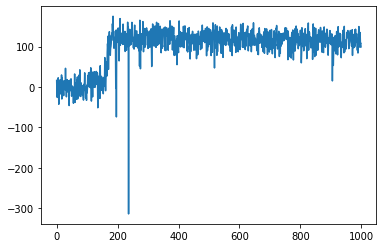

In [14]:
figure_file_rew = 'lunar-lander-rewards-sac_2000.jpg'
plt.plot(score_history)
plt.savefig(figure_file_rew)

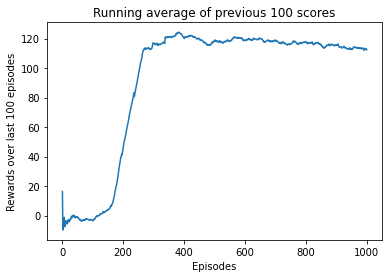

In [15]:
filename = 'lunar-lander-100avg-sac_2000.png'

x = [i+1 for i in range(num_episodes)]
plot_learning_curve(x,score_history,filename)